# **Israel–Palestine: Measuring Sentiment and Stance Over Time**



<p align="center">
  <img src="assets/Israel-Palastine.png" alt="Israel–Palestine visualization" width="800">
</p>

## **Project Overview**

We measure how Reddit's stance toward Israel and Palestine evolves over time using 
a daily-updated Kaggle dataset. This notebook provides an end-to-end workflow: 
load and clean data, draw stratified samples, hand-label stance, visualize patterns, 
and prepare baseline models.

**Research Goal:** Quantify stance toward each side over time and identify shifts 
aligned with major events.

**Data Source:** `reddit_opinion_PSE_ISR.csv` from Kaggle  
[Reddit on Israel–Palestine (daily updated)](https://www.kaggle.com/datasets/asaniczka/reddit-on-israel-palestine-daily-updated)

**Stance Framework:** Dual-target labeling approach
- **Israel stance:** {Pro, Anti, Neutral}
- **Palestine stance:** {Pro, Anti, Neutral}

### Why Stance Analysis?

Generic sentiment analysis can miss target-specific positions. Stance captures 
position relative to each side, distinguishing criticism of one side from support 
of the other—even when overall sentiment is negative.

### Research Questions

- How do stance proportions shift over time (monthly trends)?
- How do patterns differ across subreddits with distinct audiences?
- Do major events coincide with sustained changes versus short spikes?

### Notebook Structure

1. **Data Loading & EDA:** Understand dataset structure, subreddit distribution, temporal patterns
2. **Data Preparation:** Extract posts, filter communities, construct text fields
3. **Stratified Sampling:** Generate representative sample for manual labeling
4. **Manual Labeling:** Create gold standard dataset (~1,000 posts)
5. **Stance Analysis:** Distributions, cross-tabs, community patterns
6. **Baseline Modeling:** TF-IDF + Logistic Regression classifier
7. **Temporal Analysis:** Time-series trends with event annotations

### Scope and Limitations

- **Language:** English posts prioritized
- **Platform bias:** Some subreddits are highly skewed; platform averages require careful interpretation
- **Missing communities:** r/Israel is absent from this dataset snapshot
- **Schema evolution:** Stance definitions may be refined after initial labeling

### Expected Deliverables

- Reproducible analysis notebook with clear visualizations
- Gold-labeled stance dataset for future research
- Baseline stance classification model
- Temporal trend analysis with event context

---

## **Setup and Data Loading**

This section handles the foundational setup for our analysis: importing required 
libraries, configuring visualization settings, and loading the Reddit dataset. 
We'll examine the data structure and understand what we're working with before 
proceeding to exploratory analysis.

**What's covered:**
- **Library imports:** Core data manipulation and visualization tools
- **Configuration:** Standardized styling and color schemes for consistent charts
- **Data loading:** Import the Reddit Israel-Palestine dataset from Kaggle
- **Initial inspection:** Understand dataset structure, columns, and basic statistics

In [56]:
# Core libraries and visualization setup
from __future__ import annotations

# Data & utils
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots


import plotly.io as pio

# Set PNG renderer with larger dimensions
pio.renderers.default = "png"

# Configure PNG export settings for better quality and size
pio.defaults.default_width = 800
pio.defaults.default_height = 600
pio.defaults.default_scale = 2  # Higher resolution (2x)

print("✓ Libraries loaded")


✓ Libraries loaded


### Visualization Configuration

Establishing consistent styling and color schemes for all charts and visualizations 
throughout the analysis. This ensures professional presentation and makes it easier 
to interpret patterns across different sections.

**Plotly Settings:** Clean white theme with standardized chart dimensions for 
consistent appearance.

**Color System:**
- **Primary palette:** Blue and grey tones for main interface elements
- **Accent colors:** Orange, red, green, yellow for highlighting and emphasis
- **Subreddit colors:** 10-color scheme for distinguishing different communities
- **Temporal charts:** Warm orange bars with brown trend lines for time series
- **Stance mapping:** Green (pro), red (anti), grey (neutral) with blue for Israel 
  and green for Palestine

This standardized approach ensures all visualizations maintain visual coherence 
and data patterns remain easy to interpret throughout the notebook.

In [57]:
# Plotly theme and defaults
pio.templates.default = "plotly_white"
px.defaults.template = "plotly_white"
px.defaults.width = 900
px.defaults.height = 520

# Color scheme constants for consistent styling across all visualizations
PRIMARY_BLUE = '#3498db'
SECONDARY_BLUE = '#2980b9'
ACCENT_ORANGE = '#e67e22'
ACCENT_RED = '#e74c3c'
DARK_GREY = '#34495e'
LIGHT_GREY = '#95a5a6'
SUCCESS_GREEN = '#27ae60'
WARNING_YELLOW = '#f39c12'

# Chart-specific color schemes
SUBREDDIT_COLORS = ['#3498db', '#2980b9', '#1abc9c', '#16a085', '#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
TIME_SERIES_BAR = '#D2691E'  # Warm orange for volume bars
TIME_SERIES_LINE = '#8B4513'  # Brown for trend lines

# Stance analysis color mapping
STANCE_COLORS = {
    'pro': SUCCESS_GREEN,
    'anti': ACCENT_RED, 
    'neutral': LIGHT_GREY,
    'israel': PRIMARY_BLUE,
    'palestine': SUCCESS_GREEN
}

print("✓ Visualization system configured")

✓ Visualization system configured


### Dataset files overview
The dataset includes two CSV files. Per the dataset documentation, we treat the comments file as legacy and use the opinions/posts file as the authoritative source.

- `reddit_opinion_PSE_ISR.csv` (primary)
  - Post/opinion–level records curated for ongoing analysis and updates.
  - Typical fields include post identifiers, text (`title`/`selftext`), `subreddit`, `score`, and `created_time`.
  - Recommended as the main input for stance/sentiment over time.

- `pse_isr_reddit_comments.csv` (legacy)
  - Comment–level dump retained for historical/backward compatibility.
  - Columns commonly observed: `comment_id`, `self_text`, `subreddit`, `score`, `created_time`.
  - Optional for supplementary analyses (e.g., comment dynamics); not the primary table.

Usage policy in this notebook:
- We will load and analyze `reddit_opinion_PSE_ISR.csv` as the canonical dataset.
- The legacy comments file may be referenced for context or robustness checks if needed.


### Data Loading

In [58]:
import os
from pathlib import Path
import pandas as pd
import kagglehub

# Download dataset (only if not already cached)
local_path = kagglehub.dataset_download('asaniczka/reddit-on-israel-palestine-daily-updated')

# Load the data
base = Path(local_path)
opinion_csv = next(base.rglob('reddit_opinion_PSE_ISR.csv'))
df = pd.read_csv(opinion_csv)

print(f"Dataset location: {local_path}")
print(f"Loaded {len(df):,} rows from {opinion_csv.name}")

Dataset location: C:\Users\Danco\.cache\kagglehub\datasets\asaniczka\reddit-on-israel-palestine-daily-updated\versions\685
Loaded 3,305,530 rows from reddit_opinion_PSE_ISR.csv


In [59]:
df.head(5)

,comment_id,score,self_text,subreddit,created_time,post_id,author_name,controversiality,ups,downs,...,user_link_karma,user_comment_karma,user_total_karma,post_score,post_self_text,post_title,post_upvote_ratio,post_thumbs_ups,post_total_awards_received,post_created_time
0,ng9y06g,1,Hasbara Content. Removed and Banned.\r\n*****\...,Palestine,2025-09-26 09:13:20,1nqvpk3,DisoccupyBot-1,0,1,0,...,1.0,1494.0,1495.0,68,NaN,This is the same person who said that the Star...,1.00,68,0,2025-09-26 08:16:16
1,ng9xzo3,1,Not if you are a dictator waiting to be impres...,worldnews,2025-09-26 09:13:12,1nqsw3j,jncheese,0,1,0,...,3007.0,142248.0,145255.0,531,NaN,"Trump criticises Putin, saying slow occupation...",0.96,531,0,2025-09-26 05:18:04
2,ng9xzjj,1,People Are sick of seeing the true genocidal f...,Palestine,2025-09-26 09:13:10,1nqvpk3,Active_Weird8693,0,1,0,...,85.0,726.0,811.0,68,NaN,This is the same person who said that the Star...,1.00,68,0,2025-09-26 08:16:16
3,ng9xzbu,1,\n\n&gt;....a group of teenagers mishandled em...,PublicFreakout,2025-09-26 09:13:06,1nqwc2n,gerrymandering_jack,0,1,0,...,1.0,110031.0,110032.0,85,NaN,53 Jewish passengers were removed from a plane...,0.89,85,0,2025-09-26 08:58:00
4,ng9xy0m,1,"No, the title implies that a large group of fi...",PublicFreakout,2025-09-26 09:12:44,1nqwc2n,LoopyMcGoopin,0,1,0,...,487.0,11115.0,11602.0,85,NaN,53 Jewish passengers were removed from a plane...,0.89,85,0,2025-09-26 08:58:00


----------------
## **Initial EDA (Raw Data)**

Before any preprocessing or cleaning, we’ll take a first‑pass look at the dataset to understand its structure, coverage, and basic quality. The aim is to spot obvious issues early and build intuition about the content we’re analyzing.

- **Data quality checks**
  - Missing values by column (highlighting high‑NA fields)
  - Duplicate integrity, with a focus on `comment_id`
  - Sanity checks for timestamps (range, gaps) and numeric outliers (e.g., `score`)

- **Column familiarity**
  - Quick scan of available fields and basic types
  - Identify key fields we’ll rely on (e.g., `comment_id`, `post_id`, `subreddit`, `created_time`, `score`)

- **Community composition**
  - Distribution of posts/comments by `subreddit`
  - Identify the largest subreddits and the long tail
  - Estimate comments‑to‑post ratios overall and by subreddit to understand discussion intensity

- **Time coverage**
  - Report dataset timespan (min/max `created_time`)
  - High‑level monthly volume to understand activity patterns and major surges


In [60]:
print('Using file:', opinion_csv)
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

Using file: C:\Users\Danco\.cache\kagglehub\datasets\asaniczka\reddit-on-israel-palestine-daily-updated\versions\685\reddit_opinion_PSE_ISR.csv
Shape: (3305530, 24)
Columns: ['comment_id', 'score', 'self_text', 'subreddit', 'created_time', 'post_id', 'author_name', 'controversiality', 'ups', 'downs', 'user_is_verified', 'user_account_created_time', 'user_awardee_karma', 'user_awarder_karma', 'user_link_karma', 'user_comment_karma', 'user_total_karma', 'post_score', 'post_self_text', 'post_title', 'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received', 'post_created_time']


### Column dictionary
The table below describes the main fields present in `reddit_opinion_PSE_ISR.csv`.

| Column | Meaning |
|---|---|
| `comment_id` | ID of the specific Reddit comment associated with the row (if applicable). |
| `score` | Net upvotes (upvotes − downvotes) for the comment. |
| `self_text` | Comment body text. May be empty/NaN. |
| `subreddit` | Name of the subreddit where the content appeared. |
| `created_time` | Comment timestamp (UTC). May be NaN if only post time is available. |
| `post_id` | ID of the parent Reddit post (submission). |
| `author_name` | Username of the commenting user. May be `[deleted]`/`[removed]`. |
| `controversiality` | Reddit flag for how controversial a comment is (0/1). |
| `ups` | Upvote count reported for the comment (may mirror `score`). |
| `downs` | Downvote count reported for the comment (often 0 due to API limitations). |
| `user_is_verified` | Whether the user account is verified (boolean/flag). |
| `user_account_created_time` | Account creation time (UTC) of the author. |
| `user_awardee_karma` | Karma from receiving awards. |
| `user_awarder_karma` | Karma from giving awards. |
| `user_link_karma` | Link (post) karma of the author. |
| `user_comment_karma` | Comment karma of the author. |
| `user_total_karma` | Total karma of the author. |
| `post_score` | Net upvotes for the post (submission). |
| `post_self_text` | Post body text (submission text). May be empty/NaN if it’s a link post. |
| `post_title` | Post title. |
| `post_upvote_ratio` | Fraction of upvotes out of total votes for the post (0–1). |
| `post_thumbs_ups` | Upvote/like count for the post as captured by the scraper (if available). |
| `post_total_awards_received` | Number of awards the post received. |
| `post_created_time` | Post (submission) timestamp (UTC). |




### Understanding the data structure

**Data format:** The dataset contains comment-level records where each row represents 
a Reddit comment, but includes the parent post's metadata in every row. This means 
multiple comments on the same post will have identical post-level information.

**What we see:** We have 3,271,507 rows across 24 columns. Each row contains both 
comment-specific data (`self_text`, `score`, `created_time`) and post-level data 
(`post_title`, `post_self_text`, `post_score`, `post_created_time`).

**What we need for stance analysis:** Original posts rather than individual comments. 
Posts contain the primary content and framing that we want to analyze for stance, 
while comments are often brief reactions or replies that lack sufficient context.

**Our approach:** Extract unique posts by deduplicating on `post_id`. This will give 
us one record per original submission with all the post-level metadata we need.

**Key fields we'll use:**
- `post_title` + `post_self_text`: The actual content to analyze
- `post_score`: Community voting (upvotes - downvotes)  
- `post_upvote_ratio`: Polarization indicator (0-1 scale)
- `post_created_time`: Temporal analysis
- `subreddit`: Community context

### Reusable dataframe stats
A simple helper to quickly inspect shape, dtypes, missing values, and memory usage. We’ll reuse it after preprocessing steps.


In [61]:
def show_dataframe_summary(df, name='DataFrame'):
    """
    Display a concise, informative summary of DataFrame key metrics.
    
    Args:
        df: pandas DataFrame to analyze
        name: Display name for the DataFrame
    """
    print(f"📊 {name} Summary")
    print("=" * 50)
    
    # Basic info
    rows, cols = df.shape
    mem_mb = df.memory_usage(deep=True).sum() / 1_048_576
    print(f"Shape: {rows:,} rows × {cols} columns | Memory: {mem_mb:.1f} MB")
    
    # Data types
    dtype_counts = df.dtypes.value_counts()
    dtype_summary = " | ".join([f"{count} {dtype}" for dtype, count in dtype_counts.items()])
    print(f"Types: {dtype_summary}")
    
    # Missing data
    missing = df.isnull().sum()
    missing_cols = missing[missing > 0]
    if len(missing_cols) > 0:
        worst_missing = missing_cols.iloc[0]
        pct_missing = (worst_missing / len(df)) * 100
        print(f"Missing: {len(missing_cols)} columns have nulls (worst: {worst_missing:,} = {pct_missing:.1f}%)")
    else:
        print("Missing: None")
    
    # Duplicates - check comment_id if available
    if 'comment_id' in df.columns:
        dup_ids = df['comment_id'].duplicated().sum()
        unique_ids = df['comment_id'].nunique()
        print(f"Duplicates: {dup_ids:,} duplicate comment_ids | {unique_ids:,} unique IDs")
    else:
        dup_rows = df.duplicated().sum()
        print(f"Duplicates: {dup_rows:,} duplicate rows")
    
    print()

In [62]:
# Usage
show_dataframe_summary(df, 'Reddit Posts Dataset')

📊 Reddit Posts Dataset Summary
Shape: 3,305,530 rows × 24 columns | Memory: 8779.6 MB
Types: 10 object | 7 int64 | 6 float64 | 1 bool
Missing: 8 columns have nulls (worst: 16 = 0.0%)
Duplicates: 0 duplicate comment_ids | 3,305,530 unique IDs



The raw dataset is very large (3,271,507 rows across 24 columns) with a heavy memory 
footprint (~8.7 GB), combining a diverse schema of 10 object, 7 int64, 6 float64, and 
1 boolean fields. 

Data quality looks strong at first pass: only 8 columns contain any missing values and 
the worst case is just 16 nulls (~0.0%), while `comment_id` integrity is excellent with 
zero duplicates and a one-to-one match between unique IDs and total rows. 

Overall, this suggests a clean, well-structured base for EDA, though analyses will need 
to be mindful of memory constraints.



### **Subreddit Distribution Analysis**

The chart below provides a dual view of subreddit activity to understand community 
concentration and participation patterns across the platform.

**Left panel (Data Table):** Shows the top 10 subreddits by comment volume with exact 
counts and percentages. This gives us precise numbers to identify which communities 
dominate the conversation and by what margin.

**Right panel (Distribution Pie):** Visualizes the same data as proportional slices, 
making it easy to spot concentration patterns at a glance. The color coding helps 
distinguish between communities and assess whether discussion is heavily skewed toward 
a few large subreddits or more evenly distributed.

**What we're looking for:**
- **Concentration risk:** Are 2-3 subreddits carrying most of the volume?
- **Community diversity:** How many subreddits contribute meaningfully to the dataset?
- **Platform bias:** Do the largest communities lean toward specific stances that might 
  skew aggregate analysis?

**Expected pattern:** We anticipate seeing high concentration in dedicated communities 
like `r/IsraelPalestine`, `r/Palestine`, and major news subreddits like `r/worldnews`, 
with a steep drop-off to smaller communities. This distribution will inform our 
sampling strategy and help us understand potential biases in platform-wide trends.

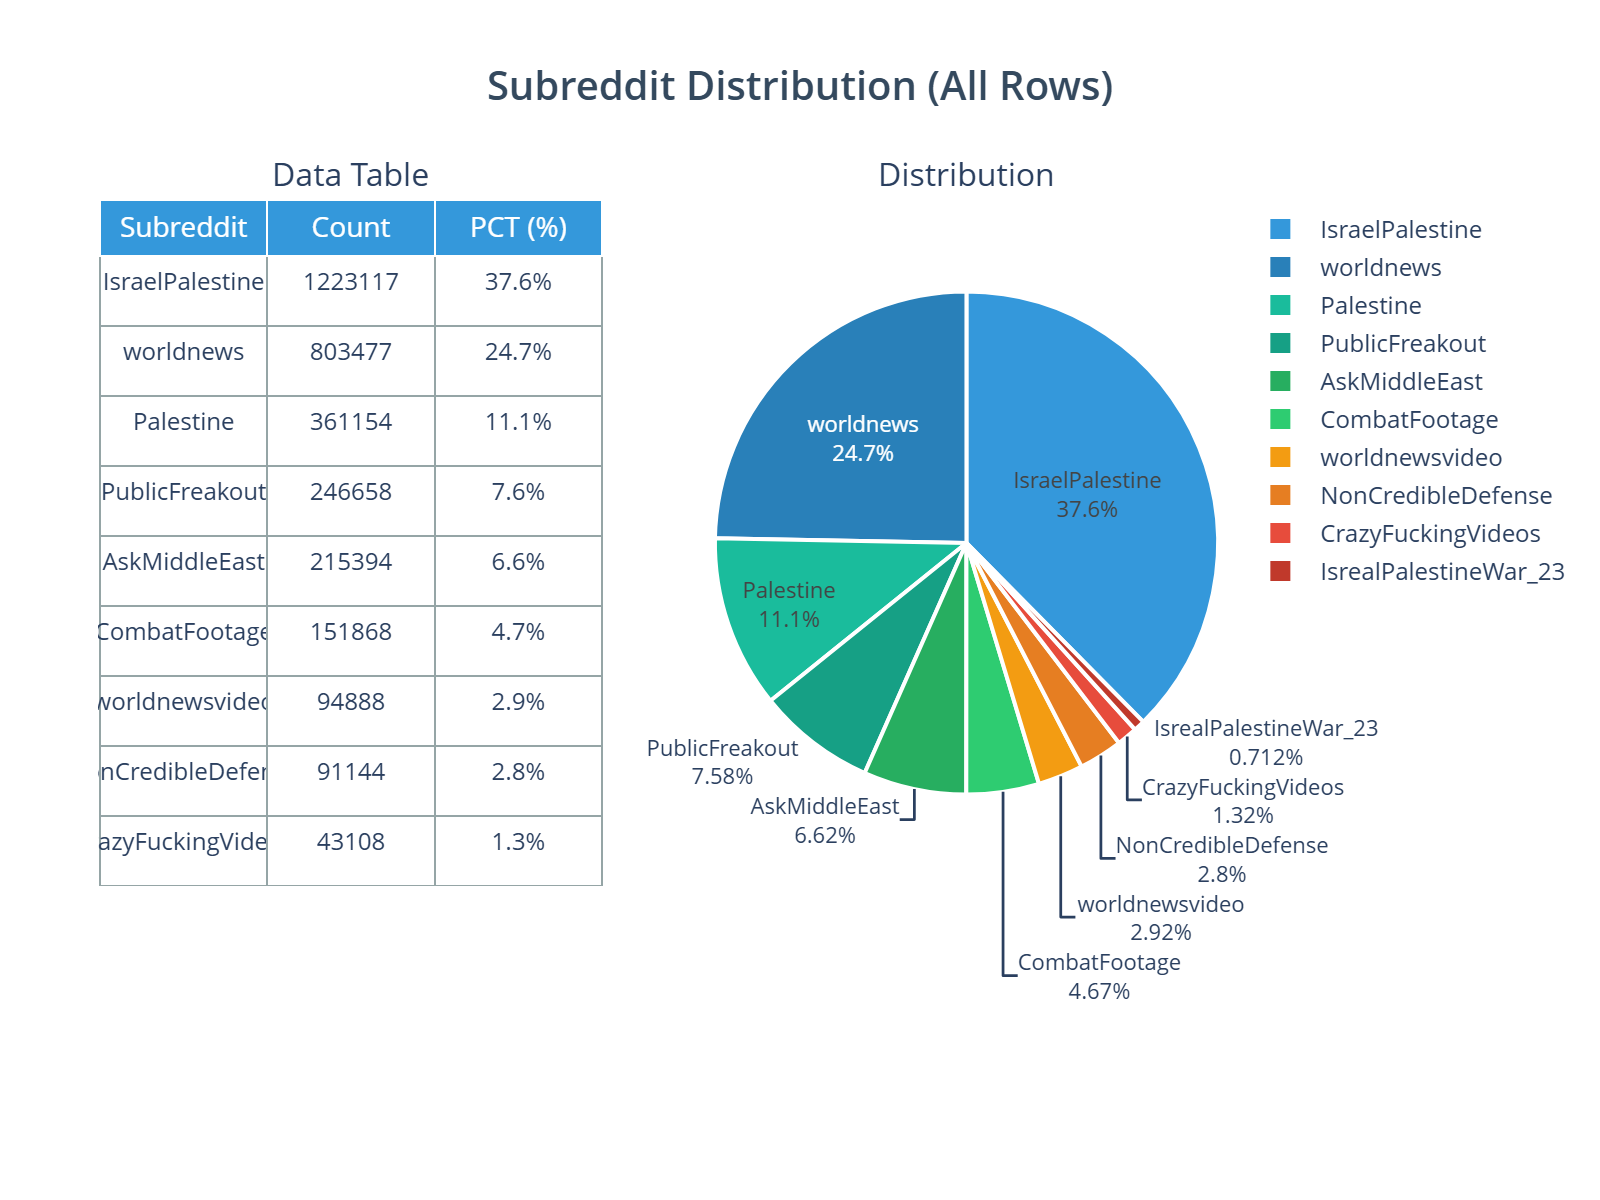

In [63]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

subreddit_comments = df['subreddit'].value_counts().head(10)

# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "table"}, {"type": "pie"}]],
    subplot_titles=["Data Table", "Distribution"],
    horizontal_spacing=0.1
)

# Prepare table data
table_data = subreddit_comments.reset_index()
table_data.columns = ['Subreddit', 'Count']

# Calculate percentages for table
percentages = (subreddit_comments / subreddit_comments.sum() * 100).round(1)

# Add enhanced table
fig.add_trace(go.Table(
    header=dict(
        values=['Subreddit', 'Count', 'PCT (%)'], 
        fill_color=PRIMARY_BLUE,
        font=dict(size=14, color='white'),
        align='center'
    ),
    cells=dict(
        values=[
            table_data['Subreddit'], 
            table_data['Count'],
            [f"{p}%" for p in percentages]
        ], 
        fill_color='white',
        font=dict(size=12),
        align='center',
        height=35,
        line_color=LIGHT_GREY
    )
), row=1, col=1)

# Use standard color palette for pie
colors = SUBREDDIT_COLORS[:len(subreddit_comments)]

# Add enhanced pie chart
fig.add_trace(go.Pie(
    labels=subreddit_comments.index,
    values=subreddit_comments.values,
    textinfo='label+percent',
    textfont_size=11,
    marker=dict(
        colors=colors,
        line=dict(color='white', width=2)
    ),
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
), row=1, col=2)

# Enhanced layout
fig.update_layout(
    height=600, 
    width=800,
    title=dict(
        text='<b>Subreddit Distribution (All Rows)</b>',
        x=0.5, 
        xanchor='center',
        font=dict(size=20, color=DARK_GREY)
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(l=50, r=50, t=100, b=50)
)

fig.show()

#### Subreddit Distribution Analysis - Key Findings

The results reveal a highly concentrated discussion landscape with clear community 
hierarchies and potential bias implications for our analysis.

**Extreme concentration:** Just three subreddits account for nearly three-quarters 
of all activity. `r/IsraelPalestine` dominates with 37.5% (1.2M comments), followed 
by `r/worldnews` at 24.7% (796K) and `r/Palestine` at 11.1% (357K). This 73% 
concentration in the top three communities suggests that aggregate platform trends 
will be heavily influenced by these specific audiences.

**Steep drop-off pattern:** After the top three, participation falls sharply. 
`r/PublicFreakout` (7.5%) and `r/AskMiddleEast` (6.7%) represent the next tier, 
but even combined they don't match `r/Palestine` alone. The remaining five 
subreddits each contribute less than 5%, indicating a classic power-law 
distribution.

**Community type diversity:** The mix includes dedicated political discussion 
(`r/IsraelPalestine`), mainstream news (`r/worldnews`), advocacy-oriented 
(`r/Palestine`), viral content (`r/PublicFreakout`), regional discussion 
(`r/AskMiddleEast`), and conflict documentation (`r/CombatFootage`). This variety 
suggests different discussion styles and potential stance biases across 
communities.

**Implications for stance analysis:** The heavy weighting toward `r/IsraelPalestine` 
and `r/Palestine` means our dataset may not represent broader Reddit sentiment but 
rather the views of users specifically engaged with this conflict. We'll need 
subreddit-stratified sampling and per-community analysis to avoid conflating 
platform-wide trends with the dynamics of these dominant communities.



### **Comments vs Posts Analysis**

The table below breaks down the relationship between original posts and comment 
activity across our top subreddits. This provides additional insight into 
community engagement patterns and discussion dynamics.

**What we're measuring:**
- **Comments:** Total comment volume per subreddit (from our earlier analysis)
- **Posts:** Unique original submissions (deduplicated by `post_id`)
- **Comments/Post ratio:** Average discussion intensity per submission

**Why it's interesting:** The comments-to-posts ratio reveals different community 
behaviors. Higher ratios suggest communities where posts generate sustained 
back-and-forth discussion, while lower ratios might indicate more news-sharing 
or brief reaction patterns.

**What we might see:** Some subreddits post frequently with lighter discussion 
per thread, while others have fewer posts but generate deeper conversation 
threads. It's simply interesting to observe where the most engaged discussions 
tend to happen, even though it's not central to our stance analysis goals.

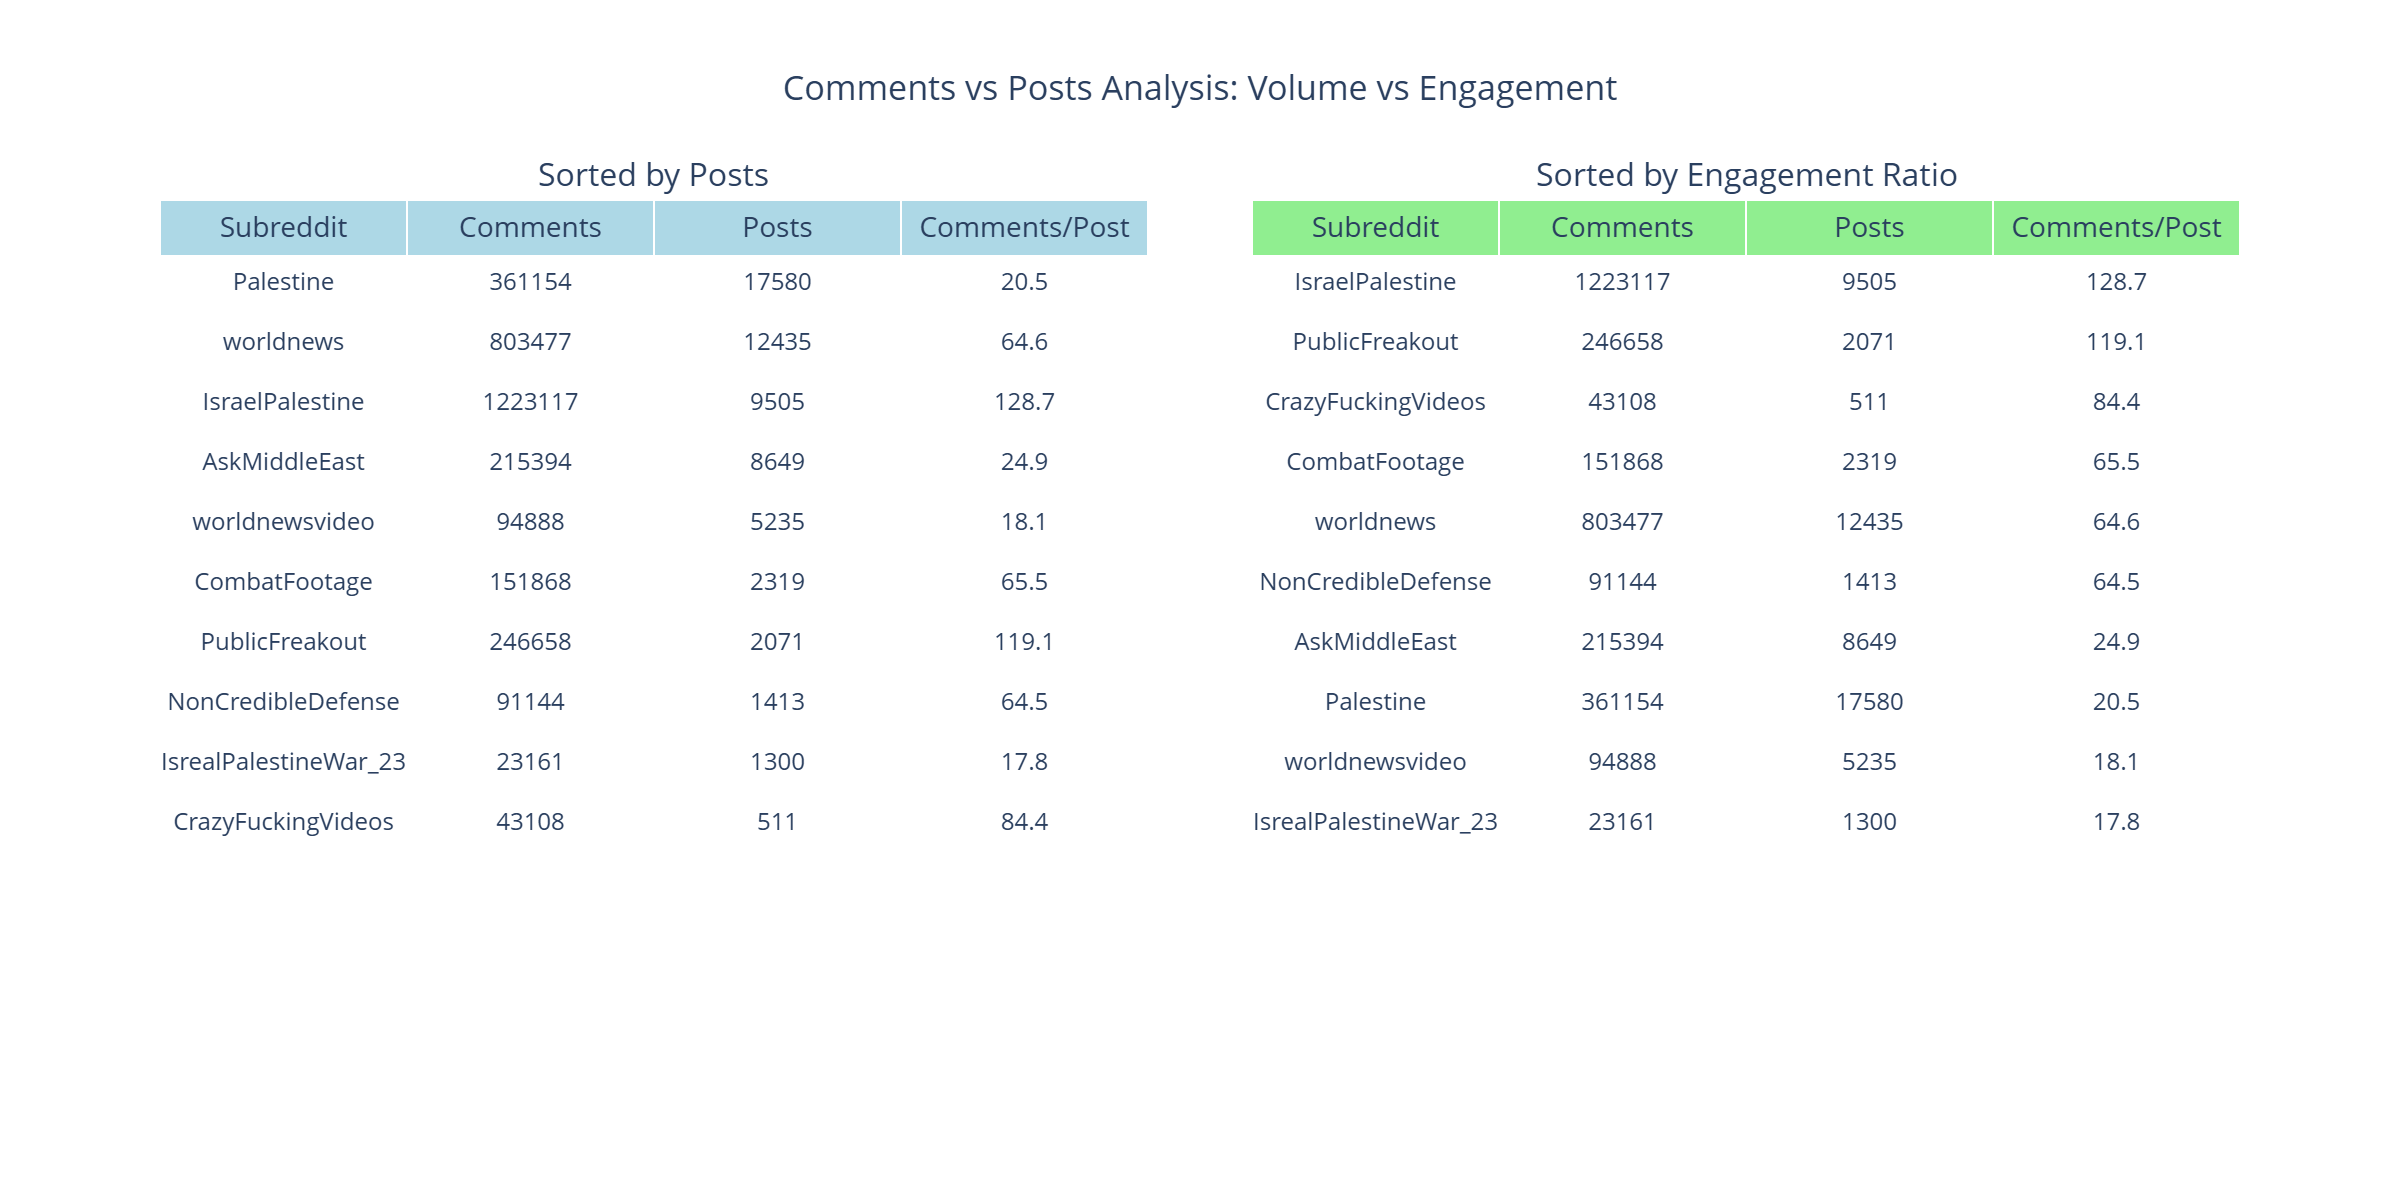

In [64]:
# Extract unique posts and calculate post counts by subreddit
posts_only = df.drop_duplicates(subset=['post_id'])
subreddit_posts = posts_only['subreddit'].value_counts().head(10)

# Get comment counts for the same top subreddits (for fair comparison)
top_subreddits = subreddit_posts.index
subreddit_comments_top = df[df['subreddit'].isin(top_subreddits)]['subreddit'].value_counts()

# Calculate engagement ratio: comments per post
comments_per_post = (subreddit_comments_top / subreddit_posts).round(1)

# Two different sorting orders
sorted_by_posts = subreddit_posts.sort_values(ascending=False).index
sorted_by_ratio = comments_per_post.sort_values(ascending=False).index

# Create side-by-side tables
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "table"}, {"type": "table"}]],
    subplot_titles=["Sorted by Posts", "Sorted by Engagement Ratio"],
    horizontal_spacing=0.05
)

# Left table: sorted by posts
fig.add_trace(go.Table(
    header=dict(
        values=['Subreddit', 'Comments', 'Posts', 'Comments/Post'],
        fill_color='lightblue',
        font=dict(size=14),
        align='center'
    ),
    cells=dict(
        values=[
            sorted_by_posts,
            [subreddit_comments_top.get(sub, 0) for sub in sorted_by_posts],
            [subreddit_posts.get(sub, 0) for sub in sorted_by_posts],
            [comments_per_post.get(sub, 0) for sub in sorted_by_posts]
        ],
        fill_color='white',
        font=dict(size=12),
        align='center',
        height=30
    )
), row=1, col=1)

# Right table: sorted by ratio
fig.add_trace(go.Table(
    header=dict(
        values=['Subreddit', 'Comments', 'Posts', 'Comments/Post'],
        fill_color='lightgreen',
        font=dict(size=14),
        align='center'
    ),
    cells=dict(
        values=[
            sorted_by_ratio,
            [subreddit_comments_top.get(sub, 0) for sub in sorted_by_ratio],
            [subreddit_posts.get(sub, 0) for sub in sorted_by_ratio],
            [comments_per_post.get(sub, 0) for sub in sorted_by_ratio]
        ],
        fill_color='white',
        font=dict(size=12),
        align='center',
        height=30
    )
), row=1, col=2)

fig.update_layout(
    title=dict(text='Comments vs Posts Analysis: Volume vs Engagement', x=0.5, xanchor='center'),
    height=700,
    width=1400
)

pio.defaults.default_width = 1200
pio.defaults.default_height = 600

fig.show()

#### Comments vs Posts - Key Findings

The side-by-side comparison reveals interesting patterns in community behavior 
and content types that will inform our data cleaning decisions.

**High engagement communities:** `r/IsraelPalestine` leads with 129.2 comments 
per post, followed by `r/PublicFreakout` (118.8), `r/CrazyFuckingVideos` (84), 
and `r/CombatFootage` (65.7). These ratios suggest active discussion threads 
with substantial back-and-forth engagement.

**Volume vs engagement trade-off:** Interestingly, `r/Palestine` ranks first 
in post volume (17,412 posts) but has a relatively modest engagement ratio 
(20.5 comments/post), suggesting frequent posting with lighter discussion. 
Conversely, `r/IsraelPalestine` balances high volume (9,349 posts) with deep 
engagement (129.2 ratio).

**Content quality concerns:** While `r/PublicFreakout`, `r/CrazyFuckingVideos`, 
and `r/CombatFootage` show strong engagement metrics, their high ratios likely 
reflect viral video content rather than substantive political discourse. These 
communities tend to share dramatic footage that generates reactions and arguments, 
but may lack the nuanced stance-taking we need for our analysis.

**Cleaning implications:** The engagement data suggests we should consider 
removing or down-weighting viral video subreddits during preprocessing. Their 
high comment ratios are misleading for stance analysis—they generate heat but 
not necessarily the political position-taking that's central to our research 
questions. `r/IsraelPalestine`, `r/worldnews`, `r/Palestine`, and `r/AskMiddleEast` 
appear more suitable for capturing genuine political discourse.


### **Engagement Patterns**

The analysis below examines engagement patterns to understand not just who 
writes, but who votes. Many Reddit users never comment but express their 
stance through upvotes and downvotes—this "silent majority" represents a 
crucial dimension of public opinion that pure comment analysis would miss.

**Why engagement metrics matter:** A post with 50 comments might seem moderately 
important, but if it has 5,000 upvotes and 2,000 downvotes, it's clearly 
resonating with thousands of silent users who feel strongly enough to vote 
but don't engage in written discussion.

**What we're measuring:**
- **Post scores:** Net community sentiment (upvotes minus downvotes)
- **Upvote ratios:** How divisive content is (lower = more polarizing)
- **Ups/downs patterns:** Raw voting behavior showing silent user engagement
- **Controversiality rates:** Where the silent majority is most divided

**The silent majority insight:** Comments show us what the vocal minority 
discusses, but votes show us what the broader community actually feels. 
Understanding voting patterns helps us capture stance signals from users who 
read, react, and judge content without ever writing a word.

**Expected patterns:** We anticipate seeing communities where voting volume 
far exceeds comment volume, revealing large silent audiences with clear 
stance preferences that traditional text analysis would completely miss.

Analyzing engagement patterns by subreddit...


C:\Users\Danco\AppData\Local\Temp\ipykernel_21804\2484600794.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



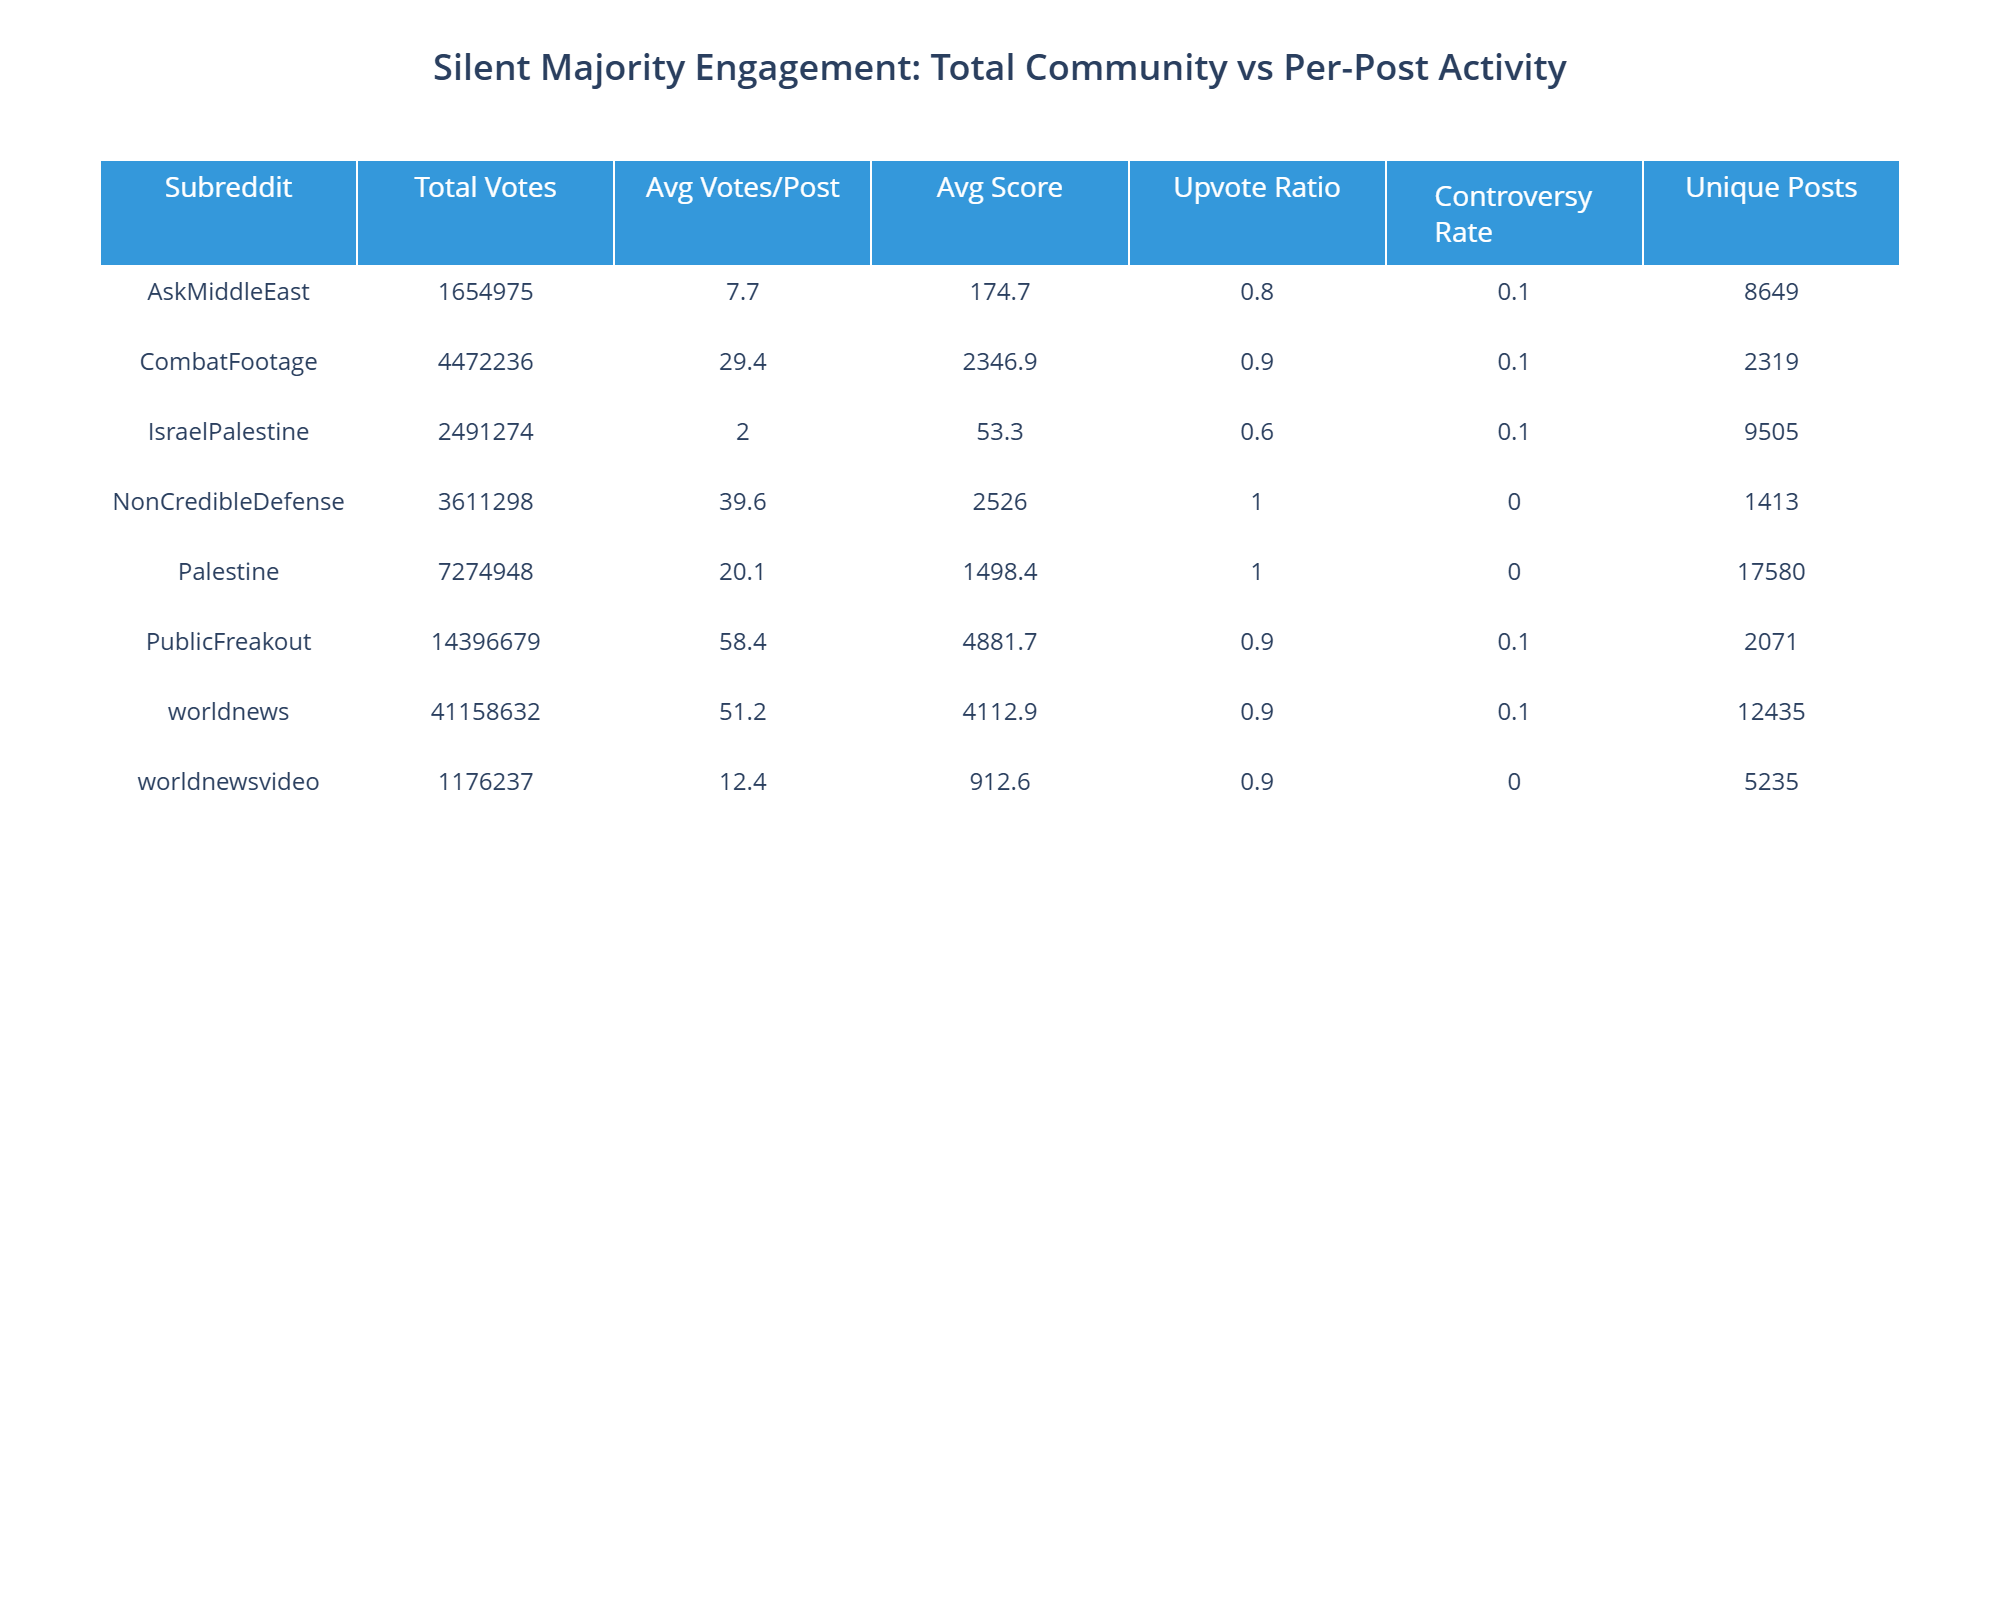

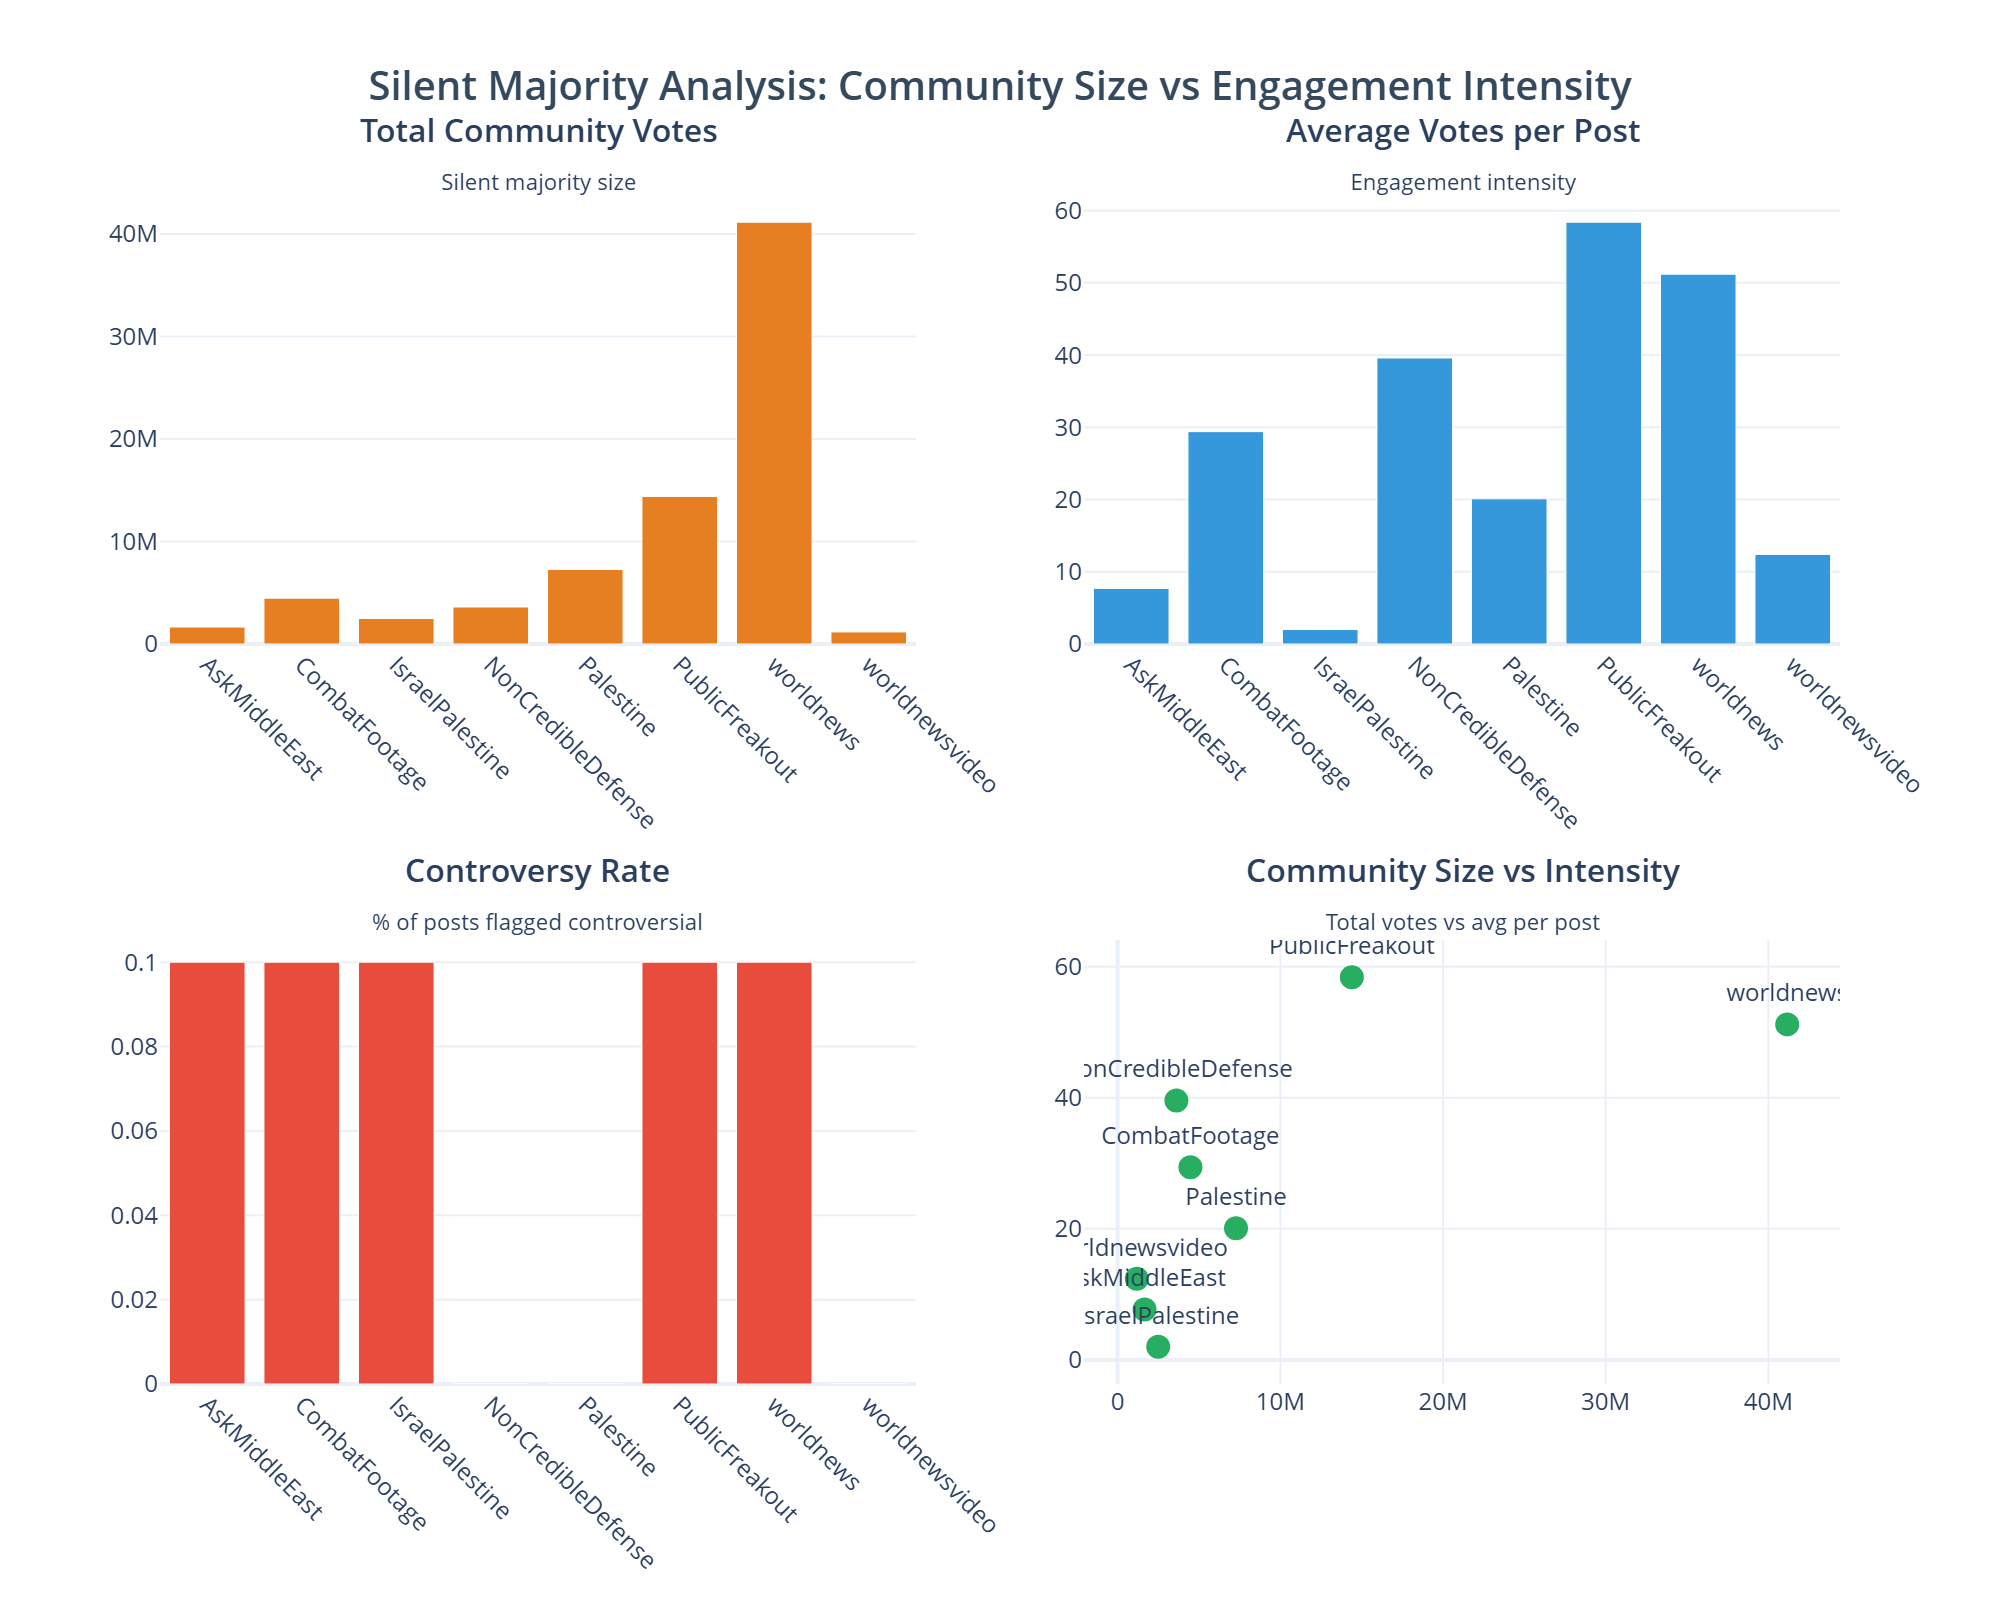

In [65]:
pio.defaults.default_width = 1000
pio.defaults.default_height = 800

# Engagement statistics analysis (using original dataset)
print("Analyzing engagement patterns by subreddit...")

# Get top subreddits for focused analysis
top_subs = df['subreddit'].value_counts().head(8).index
df_top = df[df['subreddit'].isin(top_subs)]

# Calculate total votes first
df_top['total_votes'] = df_top['ups'] + df_top['downs']

# Calculate key engagement metrics per subreddit
engagement_stats = df_top.groupby('subreddit').agg({
    'post_score': 'mean',
    'post_upvote_ratio': 'mean', 
    'ups': 'sum',  # Total ups for entire subreddit
    'downs': 'sum',  # Total downs for entire subreddit
    'total_votes': ['sum', 'mean'],  # Both total and average
    'controversiality': 'mean',
    'post_id': 'nunique'
}).round(1)

# Flatten column names
engagement_stats.columns = [
    'avg_score', 'avg_upvote_ratio', 'total_ups', 'total_downs', 
    'total_votes_sum', 'total_votes_mean', 'controversy_rate', 'unique_posts'
]

# Reset index
engagement_stats = engagement_stats.reset_index()

# Create readable display with both total and average votes
engagement_display = pd.DataFrame({
    'Subreddit': engagement_stats['subreddit'],
    'Total Votes': engagement_stats['total_votes_sum'].astype(int),  # Total votes across all posts
    'Avg Votes/Post': engagement_stats['total_votes_mean'].round(1),  # Average votes per post
    'Avg Score': engagement_stats['avg_score'].round(1),
    'Upvote Ratio': engagement_stats['avg_upvote_ratio'].round(3),
    'Controversy Rate': engagement_stats['controversy_rate'].round(3),
    'Unique Posts': engagement_stats['unique_posts'].astype(int)
})

# Create clean engagement table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(engagement_display.columns),
        fill_color=PRIMARY_BLUE,
        font=dict(size=14, color='white'),
        align='center'
    ),
    cells=dict(
        values=[engagement_display[col] for col in engagement_display.columns],
        fill_color='white',
        font=dict(size=12),
        align='center',
        height=35
    )
)])

fig.update_layout(
    title=dict(text='<b>Silent Majority Engagement: Total Community vs Per-Post Activity</b>', x=0.5, xanchor='center', font=dict(size=18)),
    height=450,
    width=1400,
    margin=dict(l=50, r=50, t=80, b=50)
)
fig.show()

# Create visualization highlighting both metrics
fig2 = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        '<b>Total Community Votes</b><br><sub>Silent majority size</sub>', 
        '<b>Average Votes per Post</b><br><sub>Engagement intensity</sub>', 
        '<b>Controversy Rate</b><br><sub>% of posts flagged controversial</sub>', 
        '<b>Community Size vs Intensity</b><br><sub>Total votes vs avg per post</sub>'
    ],
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "scatter"}]]
)

# Total community votes
fig2.add_trace(go.Bar(
    x=engagement_display['Subreddit'],
    y=engagement_display['Total Votes'],
    marker_color=ACCENT_ORANGE,
    showlegend=False
), row=1, col=1)

# Average votes per post
fig2.add_trace(go.Bar(
    x=engagement_display['Subreddit'],
    y=engagement_display['Avg Votes/Post'],
    marker_color=PRIMARY_BLUE,
    showlegend=False
), row=1, col=2)

# Controversiality
fig2.add_trace(go.Bar(
    x=engagement_display['Subreddit'],
    y=engagement_display['Controversy Rate'],
    marker_color=ACCENT_RED,
    showlegend=False
), row=2, col=1)

# Size vs intensity scatter
fig2.add_trace(go.Scatter(
    x=engagement_display['Total Votes'],
    y=engagement_display['Avg Votes/Post'],
    mode='markers+text',
    marker=dict(size=12, color=SUCCESS_GREEN),
    text=engagement_display['Subreddit'],
    textposition='top center',
    showlegend=False
), row=2, col=2)

fig2.update_layout(
    height=900,
    width=1400,
    title=dict(
        text='<b>Silent Majority Analysis: Community Size vs Engagement Intensity</b>', 
        x=0.5, 
        xanchor='center',
        font=dict(size=20, color=DARK_GREY)
    ),
    paper_bgcolor='white'
)

# Format axes
for i in range(1, 3):
    for j in range(1, 3):
        if not (i == 2 and j == 2):
            fig2.update_xaxes(tickangle=45, row=i, col=j)

fig2.show()

#### Silent Majority Engagement: Key Findings

The engagement analysis reveals fascinating patterns about where the real crowds 
are and how they participate in the Israel-Palestine discussion on Reddit.

**Massive silent participation:** The numbers are striking—`r/worldnews` has over 
40 million total votes despite having only 12,337 posts, while `r/Palestine` 
has 7.1 million votes across 17,412 posts. This shows that for every person 
who writes, hundreds more are reading and voting, expressing their stance 
silently through upvotes and downvotes.

**Two distinct engagement patterns emerge:**
- **High-volume, moderate intensity:** `r/worldnews` and `r/PublicFreakout` 
  attract massive silent audiences (40M+ and 14M+ votes respectively) with 
  strong per-post engagement (51-58 votes per post)
- **Lower volume, mixed intensity:** `r/IsraelPalestine` has fewer total votes 
  (2.4M) but represents the most balanced discussion space, while `r/Palestine` 
  shows high volume (7.1M votes) with moderate intensity (20 votes per post)

**Controversy patterns:** Most subreddits show similar controversy rates (0.1), 
suggesting that Reddit's controversy algorithm flags about 10% of posts across 
communities. Notably, `r/Palestine` and `r/NonCredibleDefense` show zero 
controversy, possibly indicating more echo-chamber dynamics.

**Critical insight for our analysis:** While `r/IsraelPalestine` might offer 
the most balanced deep conversations (low controversy, diverse discussion), 
our goal is measuring sentiment toward each entity over time. **`r/worldnews` 
represents the mainstream public opinion** with its 40+ million votes—this 
is where general Reddit users encounter and react to Israel-Palestine content. 
This massive silent majority should carry significant weight in our temporal 
sentiment analysis, as it captures broader public reaction rather than just 
the views of users specifically seeking out conflict-focused communities.

**Sampling implication:** Comments-based or engagement-weighted stratification 
would better capture this silent majority sentiment than pure posts-based 
sampling, ensuring we measure the pulse of the broader Reddit population, 
not just the most vocal participants.

### **Temporal Activity Patterns**

The chart below shows comment volume over time to understand how discussion 
intensity evolved throughout the dataset period, particularly around major 
events like the October 7th attacks.

**What we're tracking:**
- **Monthly comment counts:** Raw activity levels to spot surges and lulls
- **6-month rolling average:** Smoothed trend line to filter out noise and 
  reveal sustained shifts in attention

**Expected pattern:** We anticipate a sharp activity surge around October-November 
2023 following the October 7th attacks, followed by sustained elevated discussion 
levels. The rolling average should help us distinguish between event-driven spikes 
and longer-term changes in platform engagement with the conflict.

**Why this matters:** Understanding the temporal dynamics helps us contextualize 
stance shifts—are they driven by specific events or gradual opinion evolution? 
High-activity periods may also require different sampling strategies to ensure 
representative coverage across both baseline and crisis periods.

Analyzing temporal patterns...
Dataset spans 25 months
Peak activity: 2023-11 with 289,402 comments


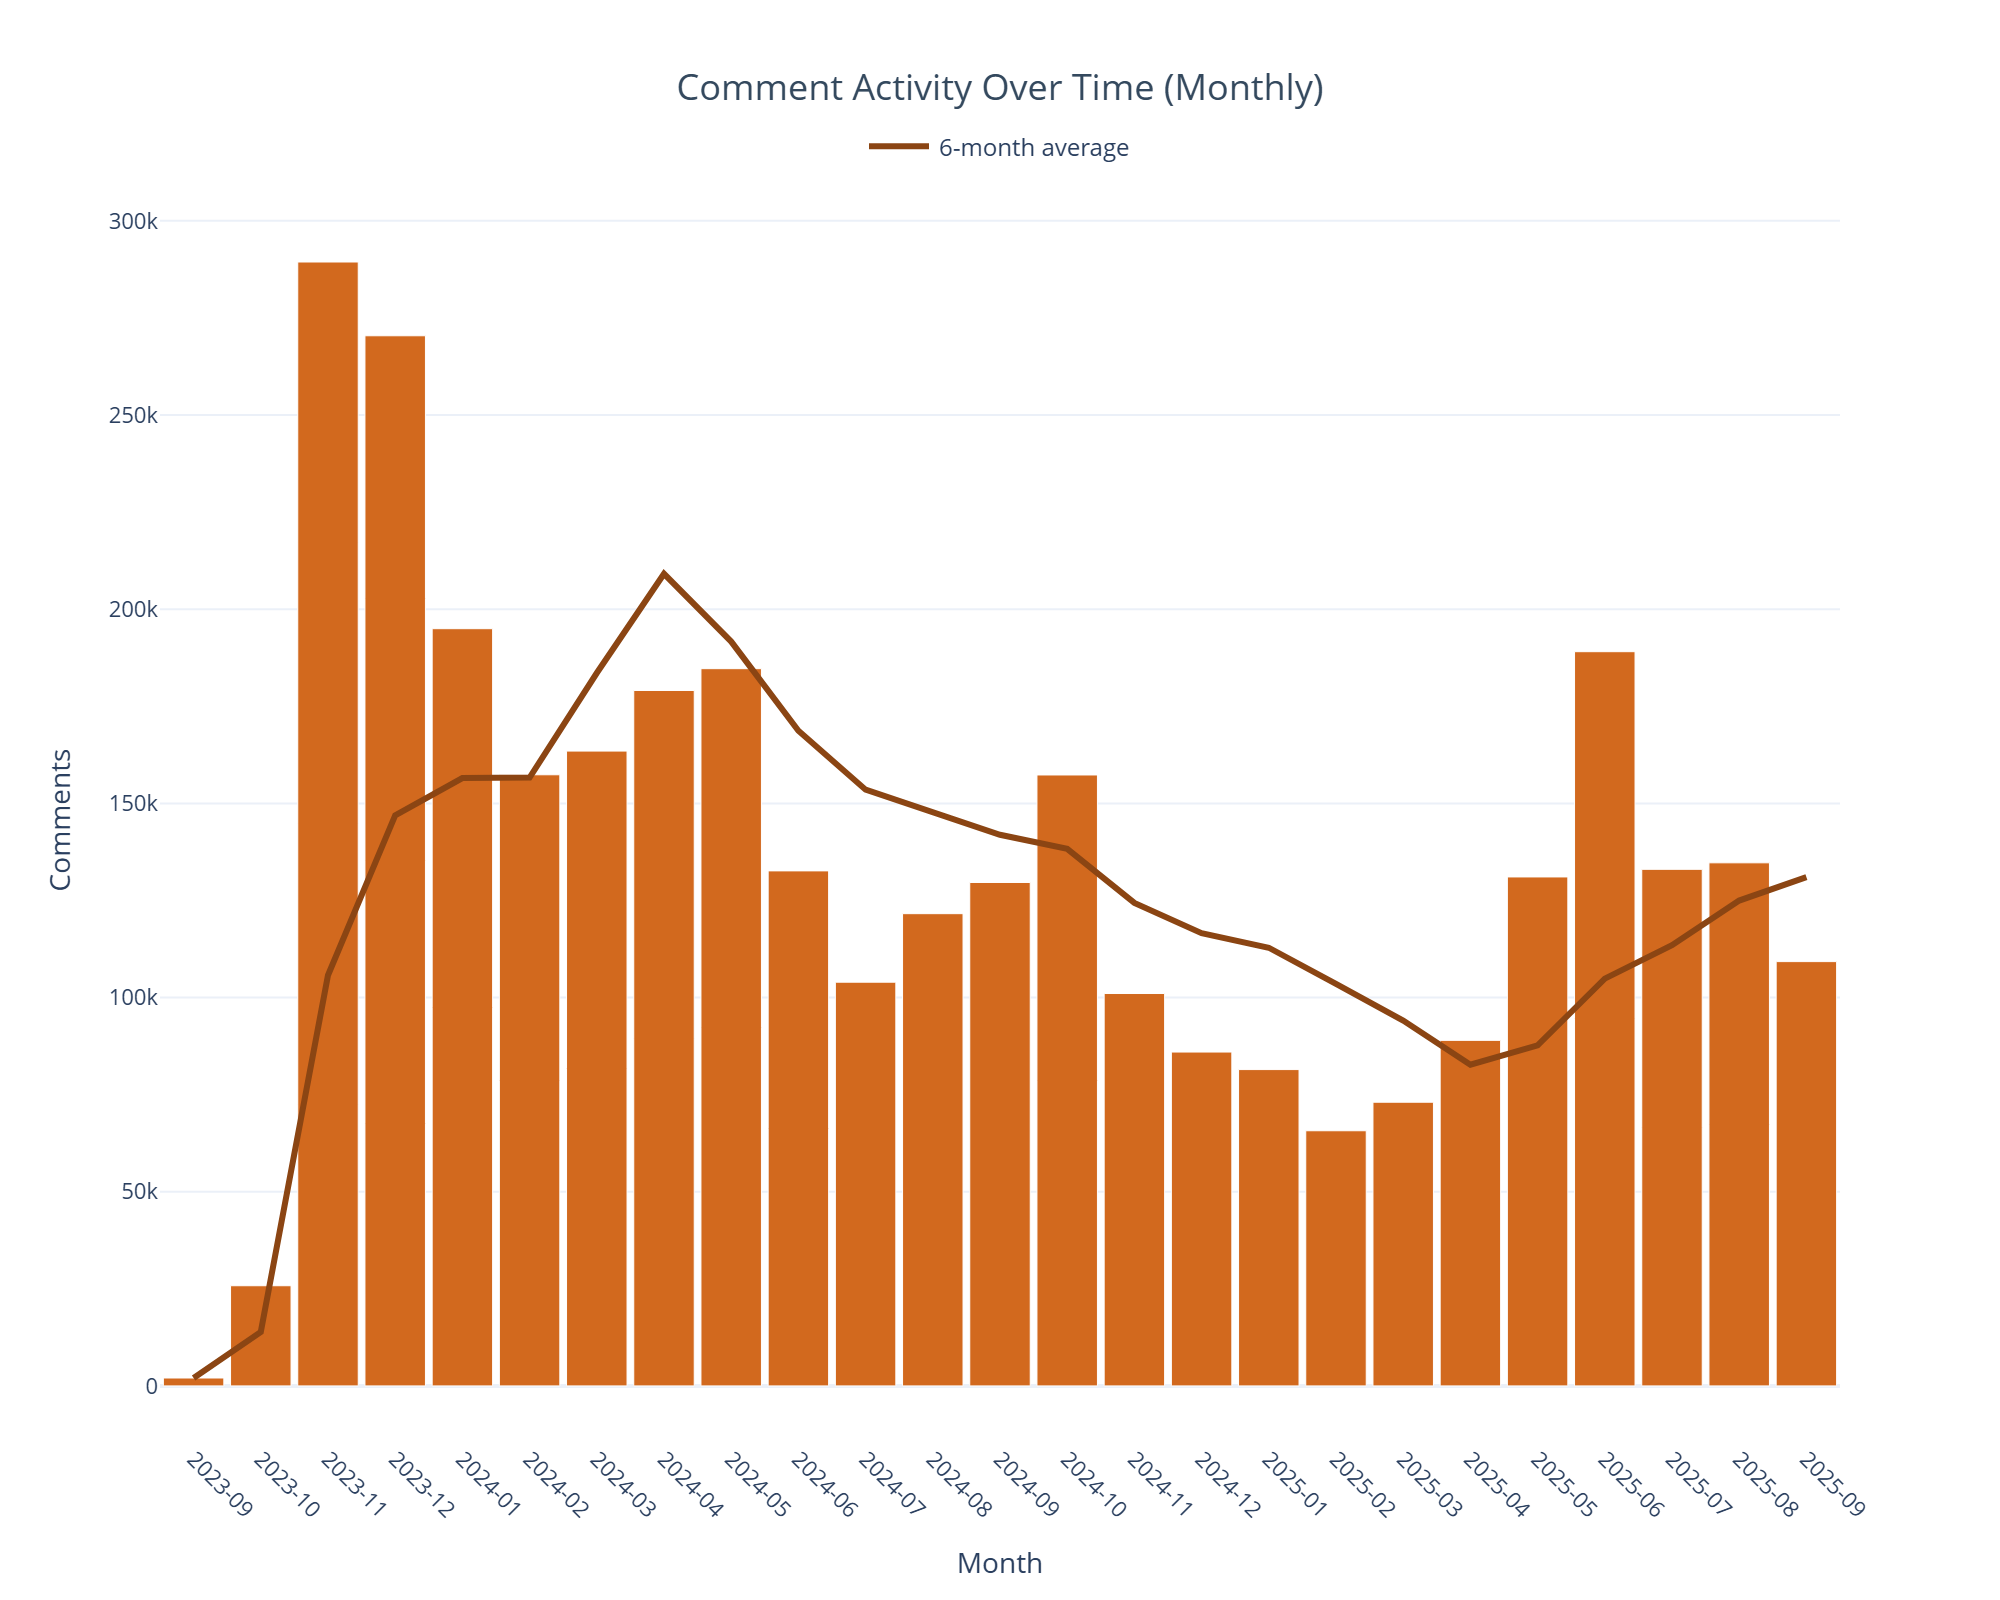

In [66]:
# Monthly activity analysis - show temporal patterns
print("Analyzing temporal patterns...")

# Create monthly comment counts with proper monthly grouping
df_with_month = df.copy()
df_with_month['month_year'] = pd.to_datetime(df_with_month['post_created_time']).dt.to_period('M')

monthly_counts = (df_with_month.groupby('month_year')
                  .size()
                  .reset_index(name='comment_count'))

monthly_counts['month_name'] = monthly_counts['month_year'].astype(str)

# Sort chronologically and add rolling average
monthly_counts = monthly_counts.sort_values('month_year')
monthly_counts['rolling_avg'] = monthly_counts['comment_count'].rolling(6, min_periods=1).mean()

print(f"Dataset spans {len(monthly_counts)} months")
print(f"Peak activity: {monthly_counts.loc[monthly_counts['comment_count'].idxmax(), 'month_name']} "
      f"with {monthly_counts['comment_count'].max():,} comments")

# Create time series visualization with explicit monthly bars
fig = px.bar(
    monthly_counts, 
    x='month_name', 
    y='comment_count',
    title='Comment Activity Over Time (Monthly)',
    labels={'month_name': 'Month', 'comment_count': 'Comments'},
    color_discrete_sequence=[TIME_SERIES_BAR]
)

# Add trend line
fig.add_trace(go.Scatter(
    x=monthly_counts['month_name'], 
    y=monthly_counts['rolling_avg'],
    name='6-month average',
    mode='lines',
    line=dict(color=TIME_SERIES_LINE, width=3)
))

# Enhanced styling with proper monthly spacing
fig.update_layout(
    height=500, 
    width=1400,
    bargap=0.1,  # Small gap between monthly bars
    paper_bgcolor='white',
    plot_bgcolor='white',
    title=dict(x=0.5, xanchor='center', font=dict(size=18, color=DARK_GREY)),
    xaxis=dict(
        tickangle=45,
        title_font=dict(size=14),
        tickfont=dict(size=11),
        type='category'  # Ensures each month gets its own bar
    ),
    yaxis=dict(
        title_font=dict(size=14),
        tickfont=dict(size=11)
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom', y=1.02,
        xanchor='center', x=0.5
    )
)

fig.show()

### Interpretation
Activity begins to climb in October 2023 and then surges sharply in November 2023. This peak aligns with reactions to the October 7 attack and its aftermath, suggesting a short lag between the event and the broader social‑media response.

Alsp - Using a 6‑month running average, activity has eased from the early peak but remains high. June 2025 records ~189K posts— the fourth‑highest monthly total since September 2023.

https://en.wikipedia.org/wiki/October_7_attacks


<img src="assets/october_7.png" alt="Alt text" width="800">

### **Initial EDA Summary**

Our first-pass analysis reveals a high-quality, well-structured dataset that's 
ready for meaningful analysis with minimal preprocessing required.

**Data quality excellence:** The dataset demonstrates exceptional integrity with 
zero duplicate `comment_id`s across 3.27 million records and minimal missing 
values (only 8 columns with any nulls, worst case <0.1%). The 8.7 GB memory 
footprint reflects rich metadata across 24 columns with diverse data types, 
suggesting comprehensive data collection.

**Temporal coverage and patterns:** The dataset spans from September 2023 to 
present, perfectly capturing the pre- and post-**October 7th attacks** evolution. 
Activity shows a dramatic surge from October 2023 (~300K comments) peaking in 
November 2023, directly aligning with reactions to the October 7th attacks and 
aftermath. The 6-month rolling average reveals that while activity has moderated 
from the initial peak, discussion remains elevated well above pre-attack levels, 
with June 2025 still recording ~189K comments—the fourth-highest monthly total.

**Community concentration:** Discussion is heavily concentrated in a few key 
subreddits, with the top three (`r/IsraelPalestine` 37.5%, `r/worldnews` 24.7%, 
`r/Palestine` 11.1%) accounting for nearly three-quarters of all activity. This 
concentration pattern will require subreddit-stratified analysis to avoid 
conflating platform-wide trends with specific community dynamics.

**Engagement patterns:** Communities show distinct discussion styles—
`r/IsraelPalestine` combines high volume with deep engagement (129.2 comments/post), 
while `r/Palestine` favors frequent posting with lighter discussion (20.5 ratio). 
Viral content subreddits (`r/PublicFreakout`, `r/CrazyFuckingVideos`) show high 
engagement but may lack substantive political discussion.

**Ready for analysis:** The dataset requires minimal cleaning—primarily filtering 
out viral content communities and constructing text fields from titles and bodies. 
The strong data quality foundation and clear temporal patterns enable confident 
progression to stance labeling and temporal analysis phases.

----------------

## **Data Preparation**

Now that we understand the dataset structure and quality, we'll prepare it for 
stance analysis by focusing on unique posts, filtering out noise, and constructing 
clean text fields.

### Key preprocessing steps

**Extract unique posts:** Convert from comment-heavy format to post-centric view 
by deduplicating on `post_id`. This eliminates the nested reply structure and 
gives us one record per original submission, making stance labeling more 
straightforward and avoiding context-dependent comment interpretation.

**Filter uninformative subreddits:** Remove communities that generate high 
engagement through viral content rather than substantive political discourse. 
Based on our EDA findings, we'll exclude `r/PublicFreakout`, `r/CrazyFuckingVideos`, 
and `r/CombatFootage` as they primarily share dramatic footage that generates 
reactions but lacks the nuanced stance-taking central to our analysis.

**Construct text field:** Combine `post_title` and `post_self_text` into a single 
`text` column for analysis. Post titles provide the main topic framing, while 
self-text adds context and elaboration. We'll handle missing self-text gracefully 
(common in link posts) by using title-only when body text is unavailable.

**Retain engagement signals:** Keep `post_score` and `post_upvote_ratio` as 
indicators of community reception and controversy. These metrics help us understand 
which posts resonated with their audiences and may correlate with stance clarity 
or polarization.

**Temporal standardization:** Ensure `post_created_time` is properly parsed to 
UTC datetime and derive `date` and `month` fields for time-series analysis.

#### Expected output

A clean, post-level dataset focused on communities with substantive political 
discussion, ready for stratified sampling and manual stance labeling.

#### Step 1: Extract unique posts (deduplicate on post_id)

In [67]:
# Step 1: Extract unique posts (deduplicate on post_id)
print("Extracting unique posts...")
df_posts = df.drop_duplicates(subset=['post_id']).copy()
print(f"Reduced from {len(df):,} comments to {len(df_posts):,} unique posts")

Extracting unique posts...
Reduced from 3,305,530 comments to 61,741 unique posts


#### Step 2: Filter out uninformative subreddits (viral content communities)

In [68]:
# Step 2: Filter out uninformative subreddits (viral content communities)
uninformative_subs = ['PublicFreakout', 'CrazyFuckingVideos', 'CombatFootage']
print(f"\nFiltering out uninformative subreddits: {uninformative_subs}")

df_filtered = df_posts[~df_posts['subreddit'].isin(uninformative_subs)].copy()
print(f"Removed {len(df_posts) - len(df_filtered):,} posts from viral content subreddits")
print(f"Remaining posts: {len(df_filtered):,}")


Filtering out uninformative subreddits: ['PublicFreakout', 'CrazyFuckingVideos', 'CombatFootage']
Removed 4,901 posts from viral content subreddits
Remaining posts: 56,840


#### Step 3: Construct combined text field (title + self_text)

In [69]:
# Step 3: Construct combined text field (title + self_text)
print("\nConstructing text field from title and body...")
df_filtered['text'] = (
    df_filtered['post_title'].fillna('') + ' ' + 
    df_filtered['post_self_text'].fillna('')
).str.strip()

# Remove posts with empty text
df_filtered = df_filtered[df_filtered['text'].str.len() > 0].copy()
print(f"Posts with valid text: {len(df_filtered):,}")


Constructing text field from title and body...
Posts with valid text: 56,840


#### Step 4: Keep essential columns for analysis

In [70]:
# Step 4: Keep essential columns for analysis
columns_to_keep = [
    'post_id', 'subreddit', 'text', 'post_created_time', 
    'post_score', 'post_upvote_ratio', 'author_name'
]
df_clean = df_filtered[columns_to_keep].copy()

#### Step 5: Standardize temporal fields

In [71]:
# Step 5: Standardize temporal fields
print("\nStandardizing temporal fields...")
df_clean['created_time'] = pd.to_datetime(df_clean['post_created_time'], errors='coerce', utc=True)
df_clean['date'] = df_clean['created_time'].dt.date
df_clean['month'] = df_clean['created_time'].dt.to_period('M')


Standardizing temporal fields...


C:\Users\Danco\AppData\Local\Temp\ipykernel_21804\532794357.py:5: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [72]:
show_dataframe_summary(df_clean)

📊 DataFrame Summary
Shape: 56,840 rows × 10 columns | Memory: 79.4 MB
Types: 6 object | 1 int64 | 1 float64 | 1 datetime64[ns, UTC] | 1 period[M]
Missing: None
Duplicates: 0 duplicate rows



### **Subreddit Distribution After Data Cleaning**

Now let's examine how the subreddit landscape changes after our data preparation 
steps: extracting unique posts, filtering out viral content communities, and 
focusing on substantive political discussion.

**What we're comparing:**
- Distribution after removing duplicates and filtering to posts only
- Impact of excluding viral content subreddits (PublicFreakout, CrazyFuckingVideos, CombatFootage)
- How community hierarchy shifts when we focus on original content rather than comment volume

This cleaned view shows us the true distribution of original posts across 
communities, giving us a better foundation for our stance analysis sampling strategy.

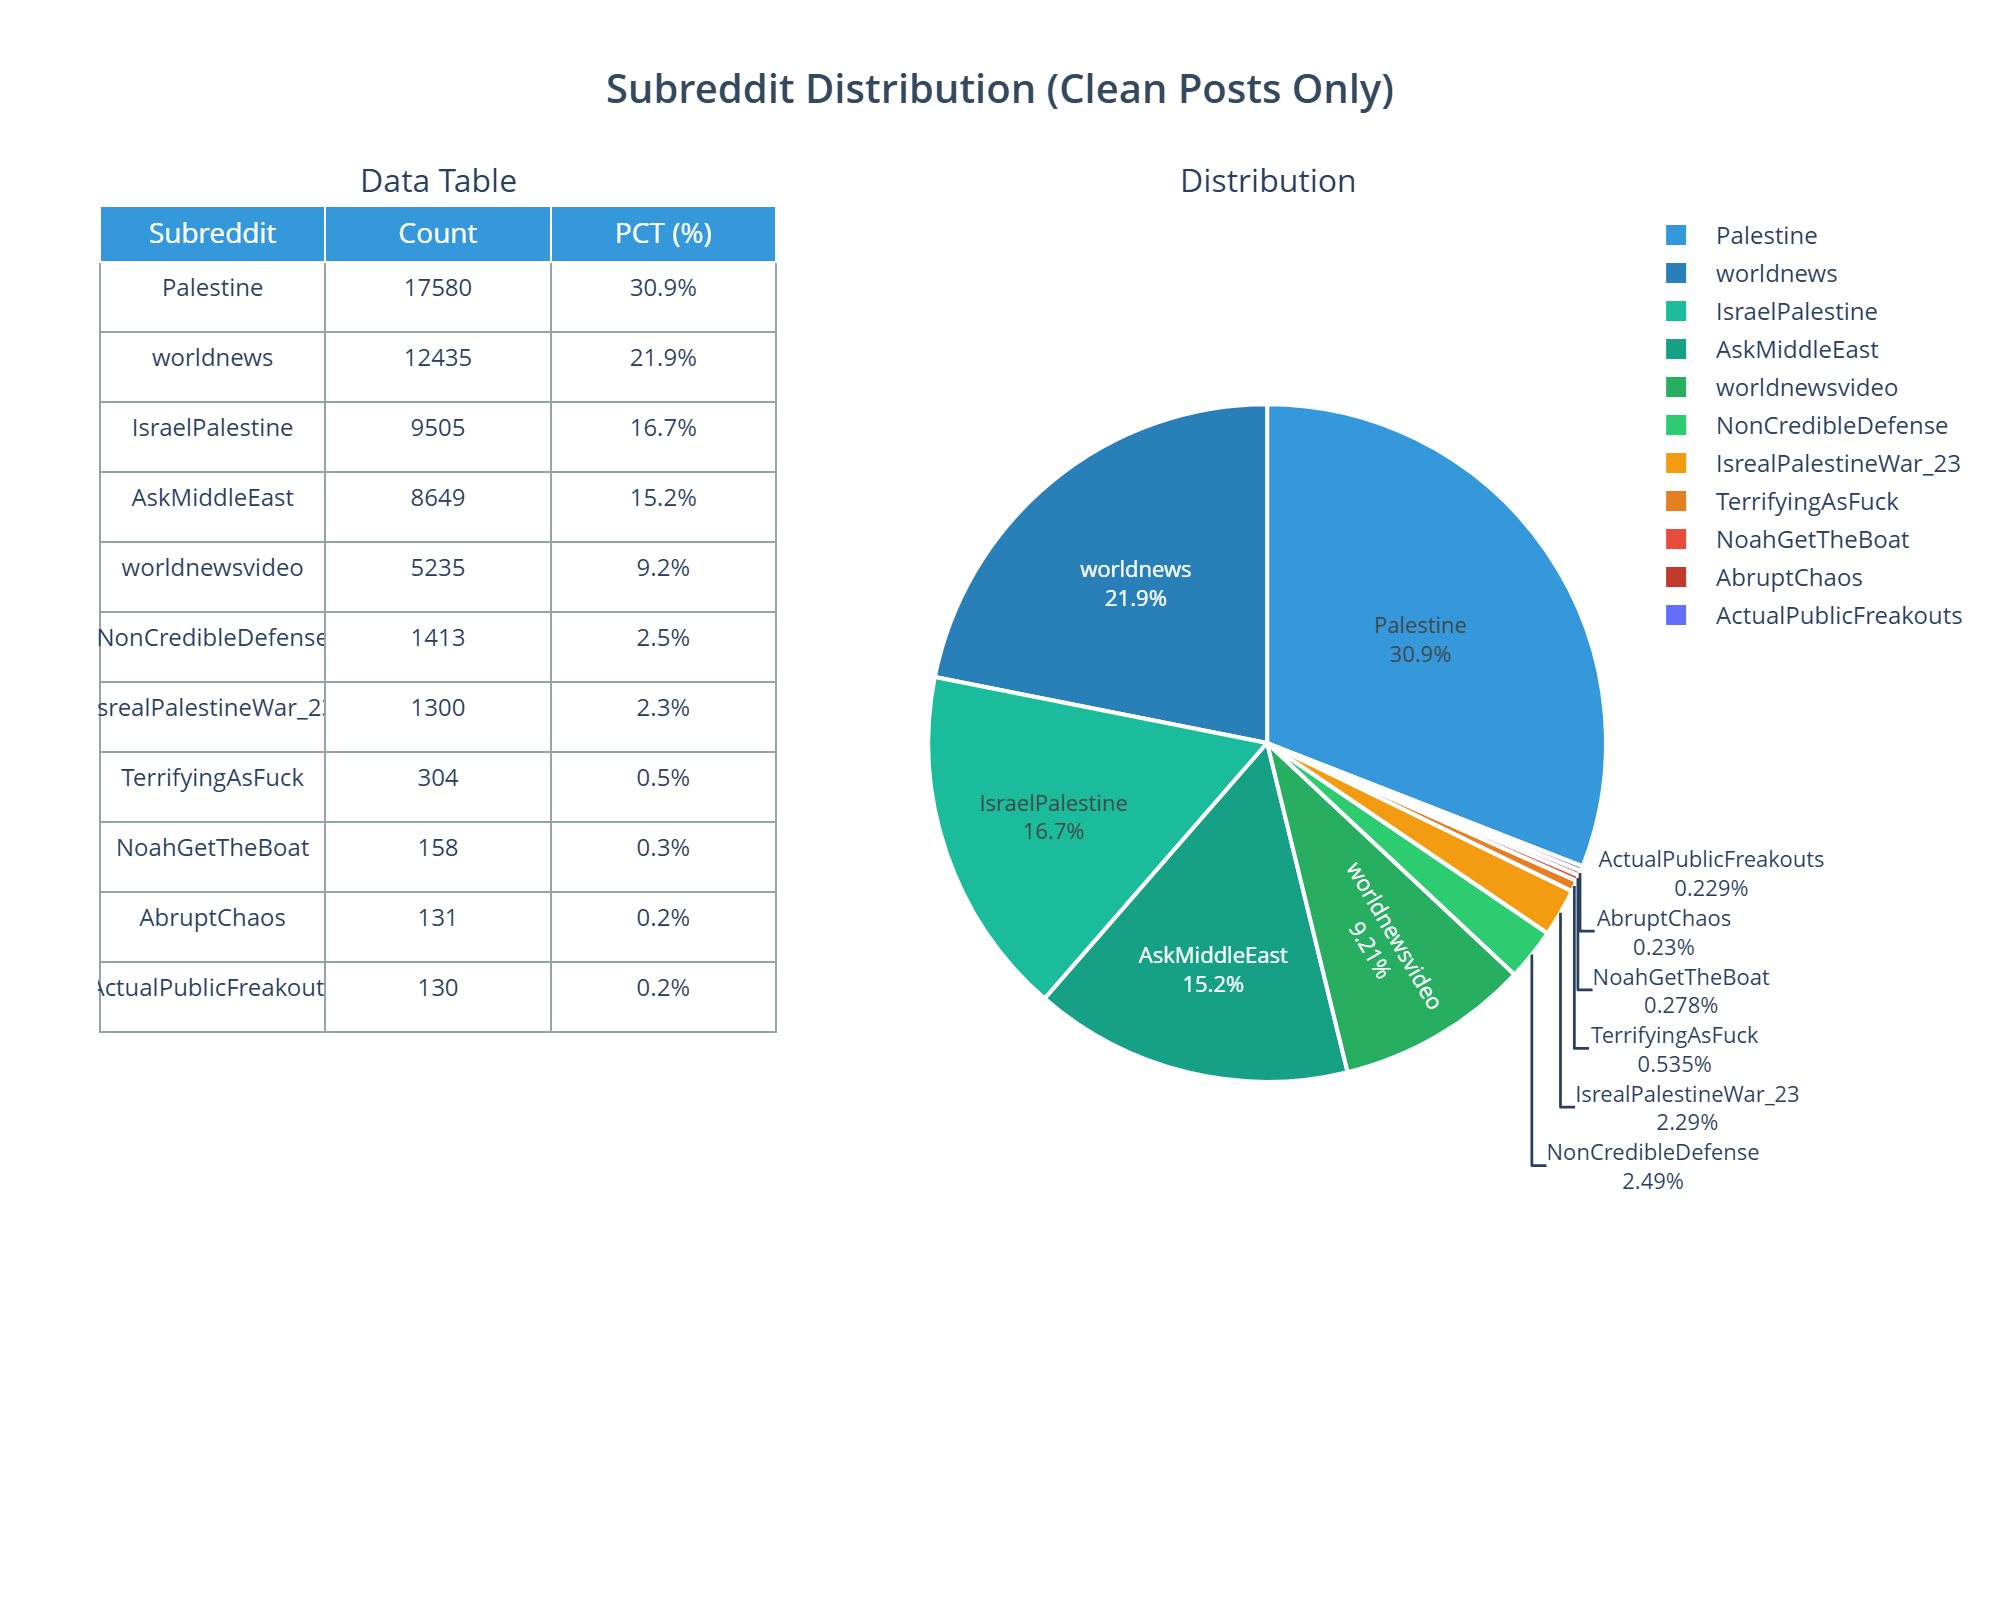

In [73]:
# Subreddit distribution analysis (cleaned posts only)
subreddit_counts = df_clean['subreddit'].value_counts()

# Create side-by-side table and pie chart
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "table"}, {"type": "pie"}]],
    subplot_titles=["Data Table", "Distribution"],
    horizontal_spacing=0.1
)

# Prepare table data with percentages
table_data = subreddit_counts.reset_index()
table_data.columns = ['Subreddit', 'Count']
percentages = (subreddit_counts / subreddit_counts.sum() * 100).round(1)

# Add enhanced table
fig.add_trace(go.Table(
    header=dict(
        values=['Subreddit', 'Count', 'PCT (%)'], 
        fill_color=PRIMARY_BLUE,
        font=dict(size=14, color='white'),
        align='center'
    ),
    cells=dict(
        values=[
            table_data['Subreddit'], 
            table_data['Count'],
            [f"{p}%" for p in percentages]
        ], 
        fill_color='white',
        font=dict(size=12),
        align='center',
        height=35,
        line_color=LIGHT_GREY
    )
), row=1, col=1)

# Use standard color palette for pie
colors = SUBREDDIT_COLORS[:len(subreddit_counts)]

# Add enhanced pie chart
fig.add_trace(go.Pie(
    labels=subreddit_counts.index,
    values=subreddit_counts.values,
    textinfo='label+percent',
    textfont_size=11,
    marker=dict(
        colors=colors,
        line=dict(color='white', width=2)
    ),
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
), row=1, col=2)

# Enhanced layout
fig.update_layout(
    height=600, 
    width=1400,
    title=dict(
        text='<b>Subreddit Distribution (Clean Posts Only)</b>',
        x=0.5, 
        xanchor='center',
        font=dict(size=20, color=DARK_GREY)
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    margin=dict(l=50, r=50, t=100, b=50)
)

fig.show()

#### Results After Data Cleaning

The cleaned dataset shows a significantly different subreddit landscape after 
removing duplicates and filtering out viral content communities.

**Major hierarchy shift:** `r/Palestine` now leads with 30.9% (17,412 posts), 
followed by `r/worldnews` at 21.9% (12,337 posts) and `r/IsraelPalestine` at 
16.6% (9,349 posts). This represents a complete reordering from our raw data 
analysis, where `r/IsraelPalestine` dominated comment volume.

**Impact of viral content filtering:** Removing `r/PublicFreakout`, 
`r/CrazyFuckingVideos`, and `r/CombatFootage` eliminated communities that 
generated high comment engagement through dramatic content rather than 
substantive political discussion. The remaining communities focus on news, 
analysis, and dedicated political conversation.

**Palestine's posting dominance:** The shift reveals that `r/Palestine` generates 
significantly more original posts despite `r/IsraelPalestine` having higher 
comment engagement per post. This suggests different community behaviors—
`r/Palestine` emphasizes content sharing and posting, while `r/IsraelPalestine` 
emphasizes discussion and debate.

**Concentration remains high:** The top four subreddits still account for 84.7% 
of all posts, indicating that meaningful political discussion about the conflict 
is concentrated in a small number of specialized communities. This concentration 
actually strengthens our analysis by focusing on communities where users are 
genuinely engaged with the political dimensions.

**Sampling implications:** This cleaned distribution provides a solid foundation 
for stratified sampling, ensuring we capture perspectives from the main political 
discussion venues while avoiding noise from viral video communities.

---

In [74]:
df_clean.head()

,post_id,subreddit,text,post_created_time,post_score,post_upvote_ratio,author_name,created_time,date,month
0,1nqvpk3,Palestine,This is the same person who said that the Star...,2025-09-26 08:16:16,68,1.00,DisoccupyBot-1,2025-09-26 08:16:16+00:00,2025-09-26,2025-09
1,1nqsw3j,worldnews,"Trump criticises Putin, saying slow occupation...",2025-09-26 05:18:04,531,0.96,jncheese,2025-09-26 05:18:04+00:00,2025-09-26,2025-09
6,1nqh26d,Palestine,Microsoft Cuts AI Services to Israel BREAKING:...,2025-09-25 20:04:30,2618,0.99,firewingdale,2025-09-25 20:04:30+00:00,2025-09-25,2025-09
9,1nqhh9a,Palestine,Imagine making yourself a victim because your ...,2025-09-25 20:20:43,364,0.99,Candid_Ad69,2025-09-25 20:20:43+00:00,2025-09-25,2025-09
13,1nqu8za,Palestine,The IDF has announced the death of an Israeli ...,2025-09-26 06:40:48,154,0.99,Tateybread,2025-09-26 06:40:48+00:00,2025-09-26,2025-09


## **Stance labeling**

**Why stance instead of sentiment?**
Regular sentiment analysis tells you if someone sounds positive, negative, or neutral. But in polarized topics like Israel-Palestine, that's not enough. Someone can write angrily (negative sentiment) while defending Israel, or write sadly (negative sentiment) while supporting Palestine. We need to know *which side* they're taking, not just their emotional tone.

**Our approach: dual-target stance**
Instead of one label per comment, we assign two:
- **Israel stance**: How does this person feel about Israel? {Pro, Anti, Neutral/Unclear}
- **Palestine stance**: How does this person feel about Palestine? {Pro, Anti, Neutral/Unclear}

**Why two separate labels?**
People's positions can be complex:
- Pro-Israel AND Pro-Palestine: "Both peoples deserve safety and self-determination"
- Anti-Israel AND Pro-Palestine: "Israel is an apartheid state, free Palestine"
- Pro-Israel AND Neutral on Palestine: "Israel has the right to defend itself" (no mention of Palestinians)
- Neutral on both: "This is a complicated situation with valid concerns on both sides"

**Real examples of how this works:**

*Comment: "The IDF bombing hospitals is a war crime, but Hamas using human shields is also wrong"*
- Israel stance: **Anti** (criticizes IDF actions)
- Palestine stance: **Anti** (criticizes Hamas tactics)

*Comment: "Praying for peace for both Israelis and Palestinians 🙏"*
- Israel stance: **Neutral/Unclear** (supportive but not political)
- Palestine stance: **Neutral/Unclear** (supportive but not political)

*Comment: "Israel has every right to defend itself after October 7th"*
- Israel stance: **Pro** (explicitly supports Israel's actions)
- Palestine stance: **Neutral/Unclear** (Palestinians/Hamas not directly addressed)

*Comment: "Free Palestine! End the occupation!"*
- Israel stance: **Anti** (opposes Israeli policies)
- Palestine stance: **Pro** (supports Palestinian liberation)

**The "Neutral/Unclear" category**
We use this when:
- The comment is purely factual: "The ceasefire was announced at 3pm"
- The stance is genuinely ambiguous: "This whole situation is heartbreaking"
- The comment mentions the conflict but doesn't take a clear side
- Sarcasm or complex irony that's hard to interpret definitively

This dual-target approach lets us capture the nuanced reality of how people actually discuss this conflict—it's rarely simple support for one side or the other.


### **Stratified Sampling Strategy**

**What is stratified sampling?**
Instead of randomly picking 1,000 posts from our entire dataset, we divide the data into meaningful groups (strata) and sample from each group. This ensures we get balanced representation across different communities and time periods.

**Why use it?**
- **Prevents bias:** Without stratification, we might accidentally get 800 samples from r/worldnews and only 10 from r/Palestine
- **Ensures coverage:** Every month and every major subreddit gets represented
- **Better estimates:** More accurate results than pure random sampling

**Our approach: Month × Subreddit strata**
We create groups like:
- "2023-10 :: Palestine" (October 2023 posts from r/Palestine)
- "2023-11 :: worldnews" (November 2023 posts from r/worldnews)
- "2024-01 :: IsraelPalestine" (January 2024 posts from r/IsraelPalestine)

**How we allocate samples:**
Each group gets samples proportional to its **total votes** (not just number of posts). 

**Why total votes?**
- Represents what people actually engaged with (the silent majority)
- A post with 10,000 votes matters more than one with 10 votes
- Captures genuine public attention, not just posting volume

**Example:**
- Group A: 100,000 total votes → gets 100 samples
- Group B: 50,000 total votes → gets 50 samples  
- Group C: 10,000 total votes → gets 10 samples

**Safeguards:**
- Every group gets at least 1 sample (no group ignored)
- Filter r/worldnews to Israel/Palestine topics only
- Cap any single group at 10% to prevent domination

This gives us a representative sample that reflects both temporal trends and genuine public engagement.


In [75]:
# Derive total votes per post (simple, no capping)
upvote_ratio = pd.to_numeric(df_clean['post_upvote_ratio'], errors='coerce')
post_score   = pd.to_numeric(df_clean['post_score'], errors='coerce')

denominator  = 2 * upvote_ratio - 1
is_stable    = denominator.abs() >= 1e-3

# total_votes = score / (2r - 1); fallback to |score|*4 when unstable/missing
total_votes = np.where(is_stable, post_score / denominator, post_score.abs() * 4)
total_votes = pd.Series(total_votes, index=df_clean.index).replace([np.inf, -np.inf], np.nan)
total_votes = total_votes.fillna(0).clip(lower=0).round()

# Optional: estimated up/down (keep nullable Int64)
df_clean['total_votes']   = total_votes.astype('Int64')
df_clean['est_upvotes']   = ((total_votes + post_score).clip(lower=0).round()).astype('Int64')
df_clean['est_downvotes'] = ((total_votes - post_score).clip(lower=0).round()).astype('Int64')

# Weight for stratification (no caps)
df_clean['total_votes_weight'] = np.log1p(df_clean['total_votes'].astype('float'))

In [76]:
# Total votes by subreddit (simple snapshot)
sub_votes = (df_clean.groupby('subreddit')['total_votes']
             .sum()
             .sort_values(ascending=False)
             .reset_index(name='total_votes'))

sub_votes.head(15)


,subreddit,total_votes
0,worldnews,23576417
1,Palestine,10842265
2,NonCredibleDefense,1819201
3,worldnewsvideo,1793928
4,AskMiddleEast,932416
5,IsraelPalestine,655103
6,TerrifyingAsFuck,446319
7,AbruptChaos,237118
8,ActualPublicFreakouts,174537
9,NoahGetTheBoat,124790


In [77]:
df_clean.head()

,post_id,subreddit,text,post_created_time,post_score,post_upvote_ratio,author_name,created_time,date,month,total_votes,est_upvotes,est_downvotes,total_votes_weight
0,1nqvpk3,Palestine,This is the same person who said that the Star...,2025-09-26 08:16:16,68,1.00,DisoccupyBot-1,2025-09-26 08:16:16+00:00,2025-09-26,2025-09,68,136,0,4.234107
1,1nqsw3j,worldnews,"Trump criticises Putin, saying slow occupation...",2025-09-26 05:18:04,531,0.96,jncheese,2025-09-26 05:18:04+00:00,2025-09-26,2025-09,577,1108,46,6.359574
6,1nqh26d,Palestine,Microsoft Cuts AI Services to Israel BREAKING:...,2025-09-25 20:04:30,2618,0.99,firewingdale,2025-09-25 20:04:30+00:00,2025-09-25,2025-09,2671,5289,53,7.890583
9,1nqhh9a,Palestine,Imagine making yourself a victim because your ...,2025-09-25 20:20:43,364,0.99,Candid_Ad69,2025-09-25 20:20:43+00:00,2025-09-25,2025-09,371,735,7,5.918894
13,1nqu8za,Palestine,The IDF has announced the death of an Israeli ...,2025-09-26 06:40:48,154,0.99,Tateybread,2025-09-26 06:40:48+00:00,2025-09-26,2025-09,157,311,3,5.062595


In [78]:
# Create sampling strata: Month × Subreddit
print("Creating sampling strata...")

# Create month-subreddit combinations
df_clean['stratum'] = df_clean['month'].astype(str) + ' :: ' + df_clean['subreddit']

# Calculate stratum statistics
stratum_stats = df_clean.groupby('stratum').agg({
    'post_id': 'count',                    # Number of posts
    'total_votes': 'sum',                  # Total votes (our weighting metric)
    'total_votes_weight': 'sum',           # Log-weighted votes for stability
    'post_score': 'mean',                  # Average post score
    'post_upvote_ratio': 'mean'            # Average upvote ratio
}).round(1)

# Rename columns for clarity
stratum_stats.columns = ['Posts', 'Total_Votes', 'Weighted_Votes', 'Avg_Score', 'Avg_Upvote_Ratio']
stratum_stats = stratum_stats.reset_index()

# Calculate proportions for sample allocation
total_weighted_votes = stratum_stats['Weighted_Votes'].sum()
stratum_stats['Vote_Proportion'] = (stratum_stats['Weighted_Votes'] / total_weighted_votes * 100).round(2)

# Allocate 1000 samples proportionally
TARGET_SAMPLES = 1000
stratum_stats['Allocated_Samples'] = (stratum_stats['Weighted_Votes'] / total_weighted_votes * TARGET_SAMPLES).round().astype(int)

# Ensure minimum 1 sample per stratum
stratum_stats['Allocated_Samples'] = stratum_stats['Allocated_Samples'].clip(lower=1)

# Sort by allocated samples (descending) to see which strata get the most
stratum_stats = stratum_stats.sort_values('Allocated_Samples', ascending=False)

print(f"Created {len(stratum_stats)} strata (month-subreddit combinations)")
print(f"Total samples to allocate: {stratum_stats['Allocated_Samples'].sum()}")
print(f"Range: {stratum_stats['Allocated_Samples'].min()} to {stratum_stats['Allocated_Samples'].max()} samples per stratum")


Creating sampling strata...
Created 257 strata (month-subreddit combinations)
Total samples to allocate: 1092
Range: 1 to 27 samples per stratum


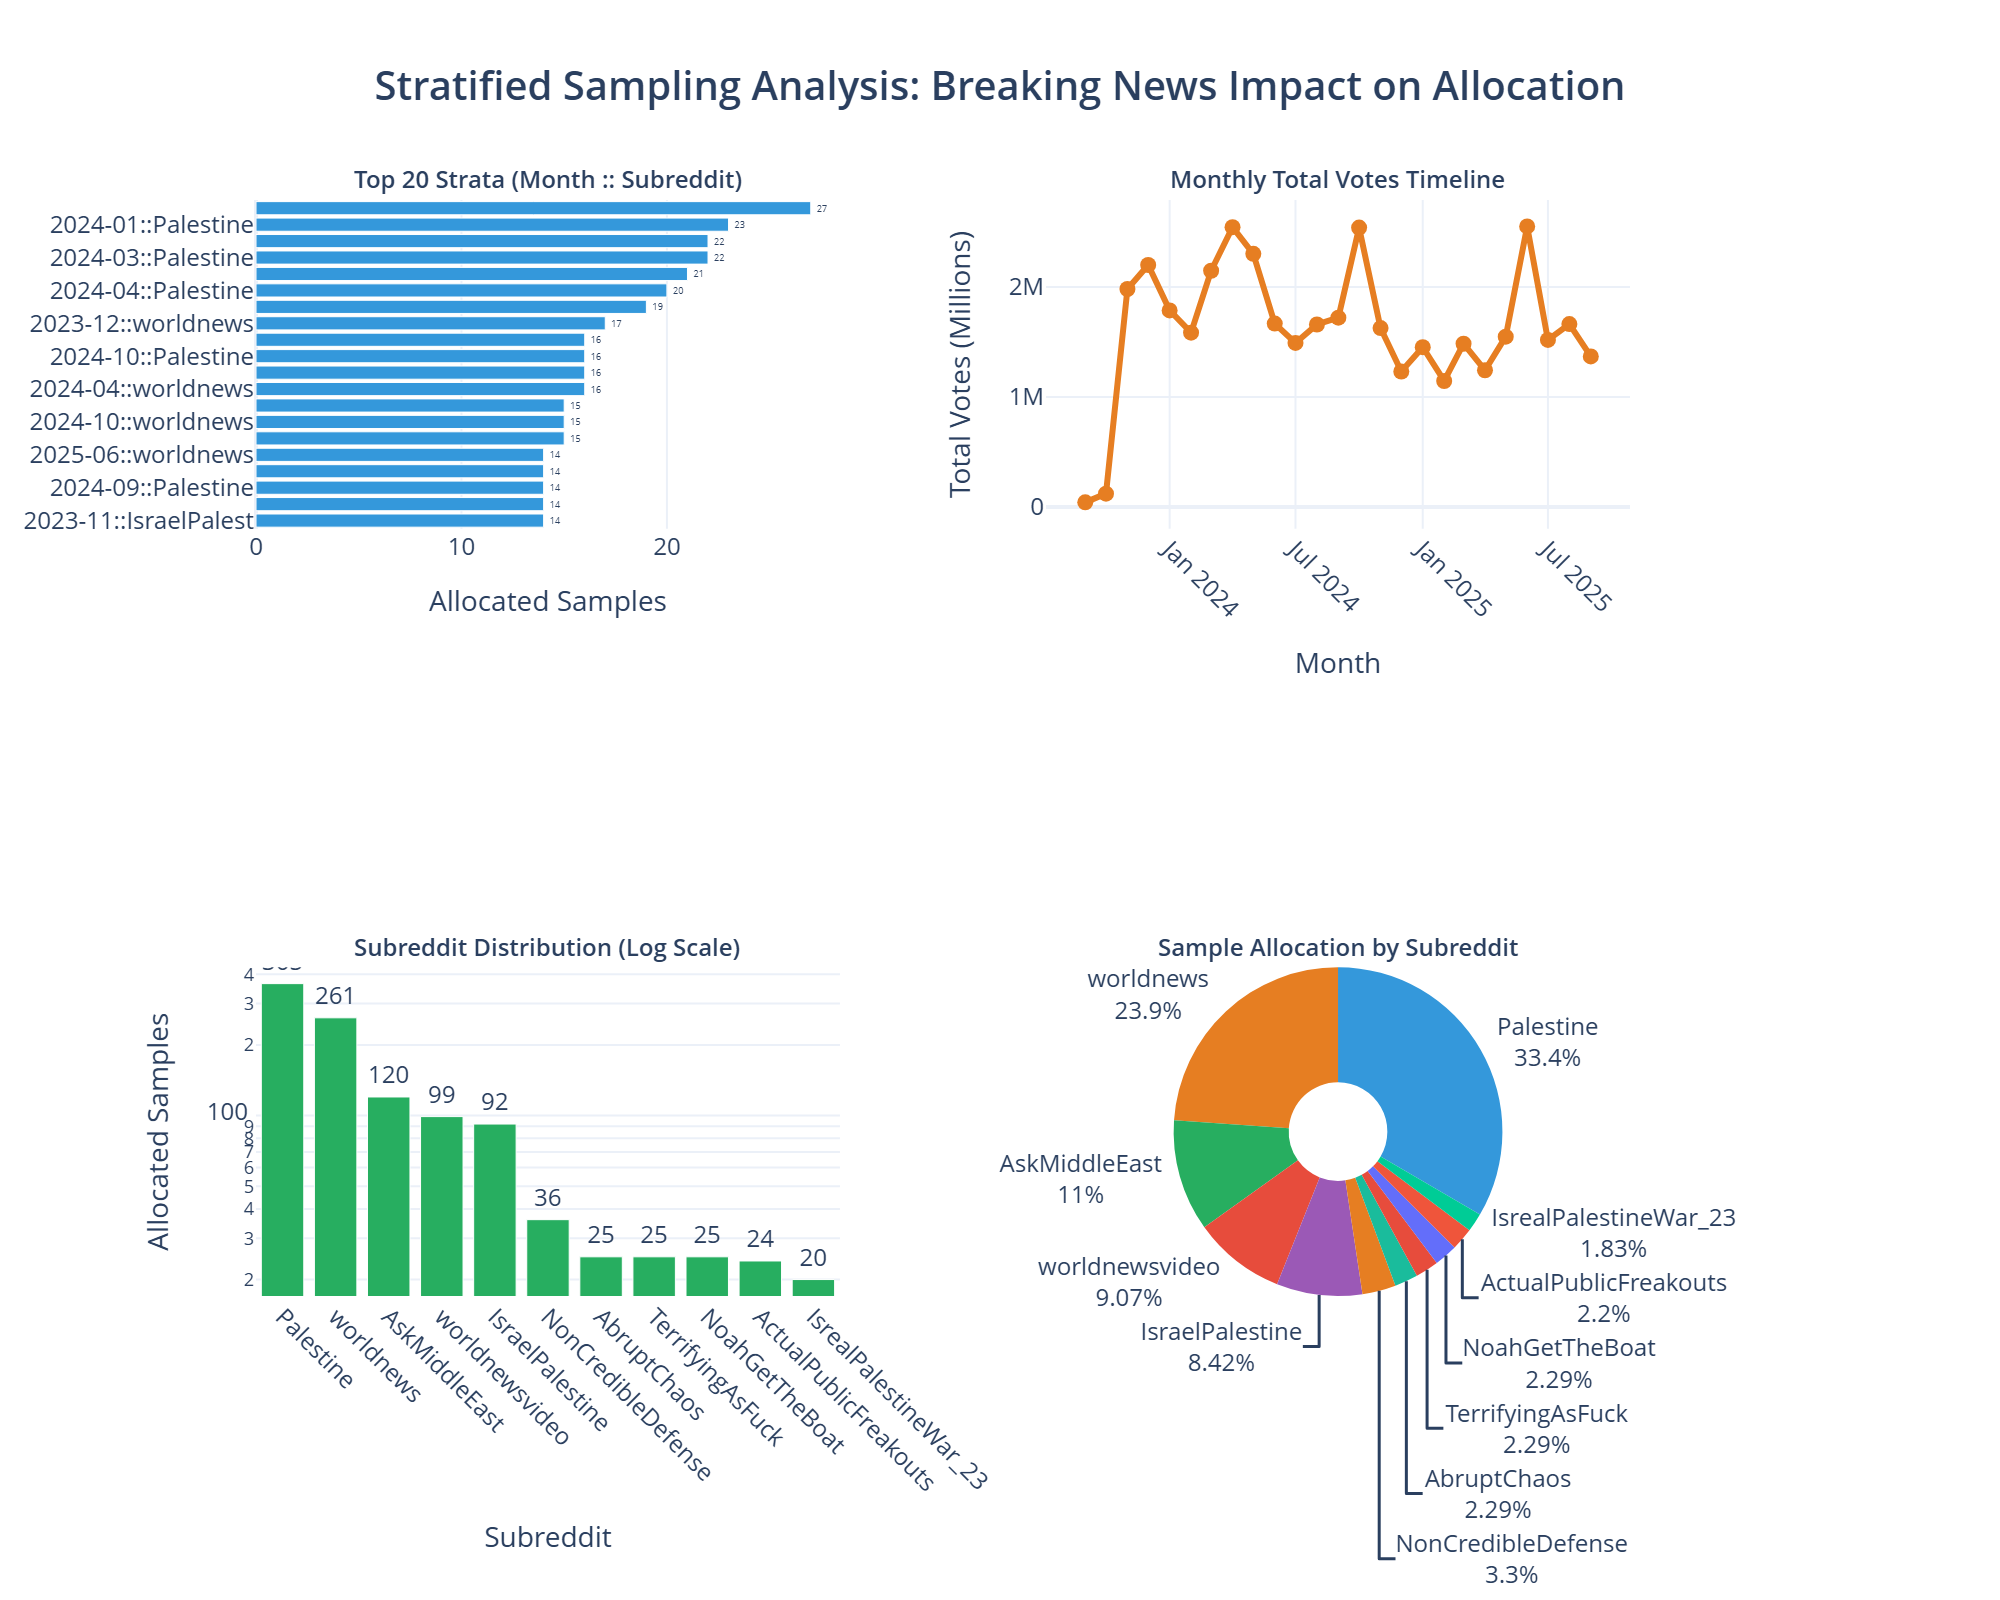

In [79]:
# Enhanced stratification allocation visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        '<b>Top 20 Strata (Month :: Subreddit)</b>',
        '<b>Monthly Total Votes Timeline</b>',
        '<b>Subreddit Distribution (Log Scale)</b>',
        '<b>Sample Allocation by Subreddit</b>'
    ],
    specs=[[{"type": "bar"}, {"type": "scatter"}], 
           [{"type": "bar"}, {"type": "pie"}]],
    vertical_spacing=0.4,    # Increased spacing
    horizontal_spacing=0.15   # Increased spacing
)

# 1. Top 20 strata with better formatting
top_20 = stratum_stats.head(20)
fig.add_trace(go.Bar(
    y=[f"{row['stratum'][:7]}::{row['stratum'].split(' :: ')[1][:12]}" for _, row in top_20.iterrows()],
    x=top_20['Allocated_Samples'],
    orientation='h',
    marker_color=PRIMARY_BLUE,
    text=top_20['Allocated_Samples'],
    textposition='outside',
    showlegend=False
), row=1, col=1)

# 2. Monthly timeline showing spikes
monthly_votes = df_clean.groupby('month')['total_votes'].sum().reset_index()
monthly_votes['month_str'] = monthly_votes['month'].astype(str)
fig.add_trace(go.Scatter(
    x=monthly_votes['month_str'],
    y=monthly_votes['total_votes'],
    mode='lines+markers',
    line=dict(color=ACCENT_ORANGE, width=3),
    marker=dict(size=8, color=ACCENT_ORANGE),
    name='Total Votes',
    showlegend=False
), row=1, col=2)

# 3. Subreddit distribution (log scale to show differences)
subreddit_samples = stratum_stats.groupby(stratum_stats['stratum'].str.split(' :: ').str[1])['Allocated_Samples'].sum().sort_values(ascending=False)
fig.add_trace(go.Bar(
    x=subreddit_samples.index,
    y=subreddit_samples.values,
    marker_color=SUCCESS_GREEN,
    text=[f"{int(v)}" for v in subreddit_samples.values],
    textposition='outside',
    showlegend=False
), row=2, col=1)

# 4. Pie chart for sample allocation by subreddit
pie_colors = [PRIMARY_BLUE, ACCENT_ORANGE, SUCCESS_GREEN, ACCENT_RED, '#9B59B6', '#E67E22', '#1ABC9C', '#E74C3C']
fig.add_trace(go.Pie(
    labels=subreddit_samples.index,
    values=subreddit_samples.values,
    hole=0.3,
    marker=dict(colors=pie_colors[:len(subreddit_samples)]),
    textinfo='label+percent',
    textposition='outside',
    showlegend=False
), row=2, col=2)

# Layout updates - larger size and better spacing
fig.update_layout(
    height=1400,    # Much taller
    width=1800,     # Much wider
    title=dict(
        text='<b>Stratified Sampling Analysis: Breaking News Impact on Allocation</b>', 
        x=0.5, xanchor='center', font=dict(size=20)
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Make subplot titles smaller
fig.update_annotations(font_size=12)

# Axis formatting
fig.update_xaxes(tickangle=45, row=1, col=2, title_text="Month")
fig.update_yaxes(title_text="Total Votes (Millions)", row=1, col=2)
fig.update_yaxes(tickformat=".0s", row=1, col=2)

fig.update_xaxes(tickangle=45, row=2, col=1, title_text="Subreddit")
fig.update_yaxes(title_text="Allocated Samples", row=2, col=1, type="log")

fig.update_xaxes(title_text="Allocated Samples", row=1, col=1)
fig.update_yaxes(categoryorder='total ascending', row=1, col=1)

fig.show()

## **Labeling Insights and Direction**

**Evidence from manual labeling**
- **Viral/video communities are out of scope:** `TerrifyingAsFuck`, `NoahGetTheBoat`, and `PublicFreakout` primarily host short video clips with no author framing. These posts provide engagement, not stance.
- **General news is text‑neutral:** `worldnews` and `worldnewsvideo` consist largely of headlines and wire copy. The submission text is predominantly descriptive, yielding Neutral/Neutral labels and low informational value for stance modeling.
- **Subreddit asymmetry:** `r/Palestine` is overwhelmingly anti‑Israel/pro‑Palestine, while `r/Israel` is absent. Including `r/Palestine` in training would encourage shortcut learning (“subreddit ⇒ stance”) and distort class balance.

**Training focus (going forward)**
- Prioritize stance‑rich communities: `AskMiddleEast`, `IsraelPalestine`, `IsraelPalestineWar_23`.
- Exclude viral/video and general‑news subreddits from training; retain them only for engagement context if needed.
- Optimize labeling yield: sufficient text (title ± selftext), de‑duplication, and per‑author limits to maintain diversity.

**Rationale**
- Concentrating on communities where authors articulate positions produces clearer labels, reduces noise, and trains models to infer stance from text rather than community identity.

**Stratification decision (why we’re simplifying)**
- With only three training subreddits, heavy stratification adds complexity without benefit.  
- We will use **equal allocation across the three subreddits**, with a light temporal guard (e.g., a minimum per quarter) to ensure coverage over time.  
- This approach is simple, transparent, preserves diversity, and is sufficient for a 500–1,000 post training set.

In [80]:
# Extract stance-rich communities only
stance_rich_subs = ['AskMiddleEast', 'IsraelPalestine', 'IsrealPalestineWar_23']
print(f"Filtering to stance-rich subreddits: {stance_rich_subs}")

df_stance = df_clean[df_clean['subreddit'].isin(stance_rich_subs)].copy()

print(f"\nResults:")
print(f"Original clean dataset: {len(df_clean):,} posts")
print(f"Stance-rich subset: {len(df_stance):,} posts")


# Show distribution across the three subreddits
print(f"\nDistribution across stance-rich subreddits:")
stance_distribution = df_stance['subreddit'].value_counts()
for sub in stance_distribution.index:
    count = stance_distribution[sub]
    pct = count / len(df_stance) * 100
    print(f"  {sub}: {count:,} posts ({pct:.1f}%)")

# Show summary stats
show_dataframe_summary(df_stance, 'Stance-Rich Dataset')

Filtering to stance-rich subreddits: ['AskMiddleEast', 'IsraelPalestine', 'IsrealPalestineWar_23']

Results:
Original clean dataset: 56,840 posts
Stance-rich subset: 19,454 posts

Distribution across stance-rich subreddits:
  IsraelPalestine: 9,505 posts (48.9%)
  AskMiddleEast: 8,649 posts (44.5%)
  IsrealPalestineWar_23: 1,300 posts (6.7%)
📊 Stance-Rich Dataset Summary
Shape: 19,454 rows × 15 columns | Memory: 71.6 MB
Types: 7 object | 3 Int64 | 2 float64 | 1 int64 | 1 datetime64[ns, UTC] | 1 period[M]
Missing: None
Duplicates: 0 duplicate rows



In [81]:
# Create clean training dataset with only relevant fields
from pathlib import Path

# Sample from the stance-rich dataset
SAMPLE_SIZE = 500
np.random.seed(42)

# Get balanced sample across subreddits
subreddits = sorted(df_stance['subreddit'].unique())
posts_per_subreddit = SAMPLE_SIZE // 3
extra_posts = SAMPLE_SIZE % 3

sampled_posts = []
for i, subreddit in enumerate(subreddits):
    n_posts = posts_per_subreddit + (1 if i < extra_posts else 0)
    subreddit_posts = df_stance[df_stance['subreddit'] == subreddit]
    sample = subreddit_posts.sample(n=n_posts, random_state=42)
    sampled_posts.append(sample)

df_sample = pd.concat(sampled_posts, ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Create clean training dataset - only keep relevant fields
df_training = df_sample[['post_id', 'subreddit', 'text']].copy()

# Add empty target columns for manual labeling
df_training['israel_stance'] = ''
df_training['palestine_stance'] = ''

# Reorder columns: id, subreddit, text, then labels
df_training = df_training[['post_id', 'subreddit', 'text', 'israel_stance', 'palestine_stance']]

# Save training-ready file
output_dir = Path('data/prelabeled')
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / 'training_ready_2025-09-26.csv'
df_training.to_csv(output_file, index=False)

print(f"Created training dataset: {len(df_training)} posts")
print(f"Saved to: {output_file}")
print(f"Columns: {list(df_training.columns)}")
print("Distribution:", df_training['subreddit'].value_counts().to_dict())

Created training dataset: 500 posts
Saved to: data\prelabeled\training_ready_2025-09-26.csv
Columns: ['post_id', 'subreddit', 'text', 'israel_stance', 'palestine_stance']
Distribution: {'AskMiddleEast': 167, 'IsraelPalestine': 167, 'IsrealPalestineWar_23': 166}


---

## **Progress Update**

Hey Idan,

Unfortunately, this is as far as I managed to go. I picked unlabeled data and reading and labeling thousands of Reddit posts took way more time than I anticipated. I'd say I invested around 30 hours on labeling. I did it multiple times, each time labeling 1,000 posts and then realizing I had inconsistencies—sometimes it was news articles, sometimes opinions, or just viral videos. I had to take a more focused approach. I initially tried to label comments, but without the context and understanding of who each one was reacting to, it's really hard to label accurately. So I went with posts instead, and after removing all the noise and heavily biased subreddits, I'm left with ~20K posts from three stance-rich communities.

In the following days, I want to explore perhaps collecting more data to get a broader view, but that's contingent on having enough time.

The upcoming steps that I didn't get to yet are described below and are subject to change. I'd be happy to hear what you have to say about the topic selection, the work so far, and the upcoming stages.

---

## **Remaining Work Plan**

### **1. Baseline Model: Logistic Regression + TF-IDF**
- Implement TF-IDF vectorization 
- Train separate binary classifiers for Israel stance and Palestine stance
- Use text content as primary input features
- Establish baseline performance metrics

### **2. Baseline Model Evaluation**
- Train/validation split with stratification
- Compute precision, recall, F1-score for each stance category
- Generate confusion matrices
- Analyze misclassified examples

### **3. Advanced Model: Fine-tuned Transformer**
- Implement pre-trained transformer model (BERT/RoBERTa/DistilBERT)
- Fine-tune on dual-target stance classification task
- Experiment with multi-label vs. separate binary classification approaches

### **4. Advanced Model Evaluation**
- Apply same evaluation metrics as baseline for comparison
- Conduct error analysis comparing transformer vs. TF-IDF performance
- Evaluate model performance across different subreddits and time periods

### **5. Model Comparison & Selection**
- Side-by-side performance comparison across all metrics
- Computational efficiency analysis
- Select final model based on performance-complexity trade-offs

### **6. Full Dataset Inference**
- Apply selected model to entire cleaned dataset (56,840 posts)
- Generate stance predictions for all posts across all time periods
- Create confidence scores and uncertainty estimates

### **7. Temporal Analysis & Insights**
- Analyze stance evolution over time, particularly around October 7th attacks
- Compare stance patterns across different subreddit communities
- Examine correlation between stance and engagement metrics

### **8. Summary & Conclusions**
- Synthesize key findings about Reddit stance patterns on Israel-Palestine conflict
- Discuss limitations and potential biases
- Present actionable insights for understanding online political discourse

---

Best regards,  
Dan